# Sélection de variables : une introduction

``` python
import sys
sys.path.insert(1, '../../../../') #insert the utils module
from utils import print_badges

#print_badges(__file__)
print_badges("content/course/modelisation/4_featureselection.qmd")
```

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/4_featureselection.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/4_featureselection.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/4_featureselection.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABmodelisation%204_featureselection%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=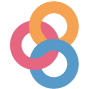" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/4_featureselection.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

Pour illustrer le travail de données nécessaire pour faire de la sélection de variables,
nous allons partir du même jeu de données que précédemment,
c’est-à-dire les résultats des élections US 2020 présentés dans l’[introduction
de cette partie](https://linogaliana-teaching.netlify.app/modelisation/): les données de vote aux élections présidentielles américaines
croisées à des variables sociodémographiques.
Le code
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/master/content/course/modelisation/get_data.py).

In [2]:
#!pip install --upgrade xlrd #colab bug verson xlrd
#!pip install geopandas

import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/course/modelisation/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

import getdata
votes = getdata.create_votes_dataframes()

Jusqu’à présent, nous avons supposé que les variables utiles à la prévision du
vote Républicain étaient connues du modélisateur. Nous n’avons ainsi exploité qu’une partie
limitée des variables disponibles dans nos données. Néanmoins, outre le fléau
computationnel que représenterait la construction d’un modèle avec un grand
nombre de variables, le choix d’un nombre restreint de variables
(modèle parcimonieux) limite le risque de sur-apprentissage.

Comment, dès-lors, choisir le bon nombre de variables et la meilleure
combinaison de ces variables ? Il existe de multiples méthodes, parmi lesquelles :

-   se fonder sur des critères statistiques de performance qui pénalisent les
    modèles non parcimonieux. Par exemple, le BIC.
-   techniques de *backward elimination*.
-   construire des modèles pour lesquels la statistique d’intérêt pénalise l’absence
    de parcimonie (ce que l’on va souhaiter faire ici).

# Principe du LASSO

## Principe général

La classe des modèles de *feature selection* est ainsi très vaste et regroupe
un ensemble très diverse de modèles. Nous allons nous focaliser sur le LASSO
(*Least Absolute Shrinkage and Selection Operator*)
qui est une extension de la régression linéaire qui vise à sélectionner des
modèles *sparses*. Ce type de modèle est central dans le champ du
*Compressed sensing* (où on emploie plutôt le terme
de *L1-regularization* que de LASSO). Le LASSO est un cas particulier des
régressions elastic-net dont un autre cas fameux est la régression *ridge*.
Contrairement à la régression linéaire classique, elles fonctionnent également
dans un cadre où $p>N$, c’est à dire où le nombre de régresseurs est très grand puisque supérieur
au nombre d’observations.

## Pénalisation

En adoptant le principe d’une fonction objectif pénalisée,
le LASSO permet de fixer un certain nombre de coefficients à 0.
Les variables dont la norme est non nulle passent ainsi le test de sélection.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 1a : Régression linéaire avec scikit</h3>

Le LASSO est un programme d’optimisation sous contrainte. On cherche à trouver l’estimateur $\beta$ qui minimise l’erreur quadratique (régression linéaire) sous une contrainte additionnelle régularisant les paramètres:

$$
\min_{\beta} \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) \\
\text{s.t. } \sum_{j=1}^p |\beta_j| \leq t
$$

Ce programme se reformule grâce au Lagrangien est permet ainsi d’obtenir un programme de minimisation plus maniable :

$$
\beta^{\text{LASSO}} = \arg \min_{\beta} \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) + \alpha \sum_{j=1}^p |\beta_j| = \arg \min_{\beta} ||y-X\beta||_{2}^{2} + \alpha ||\beta||_1
$$

où $\lambda$ est une réécriture de la régularisation précédente.

</div>

## Première régression LASSO

Avant de se lancer dans les exercices, on va éliminer quelques colonnes redondantes,
celles qui concernent les votes des partis concurrents (forcément très
corrélés au vote Républicain…) :

In [3]:
df2 = votes.loc[:,~votes.columns.str.endswith(
  ('_democrat','_green','_other', 'per_point_diff', 'per_dem')
  )]

In [4]:
# packages utiles
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
import seaborn as sns

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 1 : Premier LASSO</h3>

On cherche toujours à prédire la variable `per_gop`.

1.  Préparez les variables à utiliser.

-   Ne garder que les colonnes numériques (idéalement on transformerait
    les variables non numériques en numériques)
-   Remplacer les valeurs infinies par des NaN et les valeurs manquantes par 0.
-   Standardiser les *features* (c’est-à-dire les variables autres que la variable `per_gop`) avec `StandardScaler`

1.  On cherche toujours à prédire la variable `per_gop`. Créez un échantillon d’entraînement et un échantillon test.

2.  Estimer un modèle LASSO pénalisé avec $alpha = 0.1$. Afficher les valeurs des coefficients. Quelles variables ont une valeur non nulle ?

3.  Montrer que les variables sélectionnées sont parfois très corrélées.

4.  Comparer la performance de ce modèle parcimonieux avec celle d’un modèle avec plus de variables

``` python
#1. Garder uniquement les variables numériques et standardiser.
df2 = votes.loc[:,~votes.columns.str.endswith(('_democrat','_green','_other', 'per_point_diff', 'per_dem'))]
df2 = df2.select_dtypes(include=np.number)
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2 = df2.fillna(0)
col_names = df2.loc[:, df2.columns != 'per_gop'].columns.values
features = df2[col_names]
features = StandardScaler().fit(features.values).transform(features.values)
df2[col_names] = features
#df2.head()
```

``` python
#2. Echantillon d'entraînement et échantillon test
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["per_gop"], axis = 1),
    100*df2[['per_gop']].values.ravel(), test_size=0.2, random_state=0
)
```

A l’issue de la question 3,
les variables sélectionnées sont :

``` python
#3. Estimer un modèle LASSO et afficher les valeurs des coefficients
lasso1 = Lasso(fit_intercept=True,normalize=False, alpha = 0.1).fit(X_train,y_train)

#np.abs(lasso1.coef_)
features_selec = df2.select_dtypes(include=np.number).drop("per_gop", axis = 1).columns[np.abs(lasso1.coef_)>0].tolist()
features_selec
# Le modèle est assez parcimonieux puisque 
# un sous-échantillon de variables sont sélectionnées 
```

    /miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning:

    'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.

    ['ALAND',
     'FIPS_y',
     'INTERNATIONAL_MIG_2017',
     'DOMESTIC_MIG_2014',
     'DOMESTIC_MIG_2017',
     'RESIDUAL_2010',
     'RESIDUAL_2019',
     'R_death_2012',
     'R_death_2019',
     'R_NATURAL_INC_2019',
     'R_INTERNATIONAL_MIG_2011',
     'R_DOMESTIC_MIG_2012',
     "Percent of adults with a bachelor's degree or higher, 1990",
     'Percent of adults with a high school diploma only, 2000',
     "Percent of adults with a bachelor's degree or higher, 2000",
     "Percent of adults with a bachelor's degree or higher, 2015-19",
     'Rural_urban_continuum_code_2013',
     'Metro_2013',
     'Unemployment_rate_2002',
     'Unemployment_rate_2003',
     'Unemployment_rate_2012',
     'Rural-urban_Continuum_Code_2003',
     'Rural-urban_Continuum_Code_2013',
     'CI90LB517P_2019',
     'candidatevotes_2016_republican',
     'share_2012_republican',
     'share_2016_republican']

Certaines variables font sens, comme les variables d’éducation par exemple. Notamment, un des meilleurs prédicteurs pour le score des Républicains en 2020 est… le score des Républicains (et mécaniquement des démocrates) en 2016.

Par ailleurs, on sélectionne des variables redondantes. Une phase plus approfondie de nettoyage des données serait en réalité nécessaire.

``` python
#4. Corrélations entre les variables sélectionnées
corr = df2[features_selec].corr()

plt.figure()
p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
p
```

    /tmp/ipykernel_351/551008981.py:5: FutureWarning:

    this method is deprecated in favour of `Styler.format(precision=..)`

<style type="text/css">
#T_1a2f1_row0_col0, #T_1a2f1_row1_col1, #T_1a2f1_row2_col2, #T_1a2f1_row3_col3, #T_1a2f1_row4_col4, #T_1a2f1_row5_col5, #T_1a2f1_row6_col6, #T_1a2f1_row7_col7, #T_1a2f1_row8_col8, #T_1a2f1_row9_col9, #T_1a2f1_row10_col10, #T_1a2f1_row11_col11, #T_1a2f1_row12_col12, #T_1a2f1_row13_col13, #T_1a2f1_row14_col14, #T_1a2f1_row15_col15, #T_1a2f1_row16_col16, #T_1a2f1_row16_col22, #T_1a2f1_row17_col17, #T_1a2f1_row18_col18, #T_1a2f1_row19_col19, #T_1a2f1_row20_col20, #T_1a2f1_row21_col21, #T_1a2f1_row22_col16, #T_1a2f1_row22_col22, #T_1a2f1_row23_col23, #T_1a2f1_row24_col24, #T_1a2f1_row25_col25, #T_1a2f1_row26_col26 {
  background-color: #b40426;
  color: #f1f1f1;
}
#T_1a2f1_row0_col1, #T_1a2f1_row0_col15, #T_1a2f1_row1_col0, #T_1a2f1_row1_col10, #T_1a2f1_row1_col17, #T_1a2f1_row1_col19, #T_1a2f1_row2_col19, #T_1a2f1_row2_col23, #T_1a2f1_row5_col17, #T_1a2f1_row10_col1, #T_1a2f1_row15_col0, #T_1a2f1_row17_col1, #T_1a2f1_row17_col5, #T_1a2f1_row19_col1, #T_1a2f1_row19_col2, #T_1a2f1_row23_col2 {
  background-color: #d3dbe7;
  color: #000000;
}
#T_1a2f1_row0_col2, #T_1a2f1_row0_col11, #T_1a2f1_row0_col25, #T_1a2f1_row1_col12, #T_1a2f1_row1_col14, #T_1a2f1_row2_col0, #T_1a2f1_row3_col14, #T_1a2f1_row5_col11, #T_1a2f1_row5_col23, #T_1a2f1_row6_col12, #T_1a2f1_row6_col14, #T_1a2f1_row6_col17, #T_1a2f1_row11_col0, #T_1a2f1_row11_col5, #T_1a2f1_row11_col26, #T_1a2f1_row12_col1, #T_1a2f1_row12_col6, #T_1a2f1_row14_col1, #T_1a2f1_row14_col3, #T_1a2f1_row14_col6, #T_1a2f1_row17_col6, #T_1a2f1_row23_col5, #T_1a2f1_row25_col0, #T_1a2f1_row26_col11 {
  background-color: #d8dce2;
  color: #000000;
}
#T_1a2f1_row0_col3, #T_1a2f1_row1_col25, #T_1a2f1_row1_col26, #T_1a2f1_row2_col11, #T_1a2f1_row3_col0, #T_1a2f1_row4_col5, #T_1a2f1_row4_col13, #T_1a2f1_row5_col4, #T_1a2f1_row6_col9, #T_1a2f1_row9_col6, #T_1a2f1_row11_col2, #T_1a2f1_row13_col4, #T_1a2f1_row25_col1, #T_1a2f1_row26_col1 {
  background-color: #dadce0;
  color: #000000;
}
#T_1a2f1_row0_col4, #T_1a2f1_row0_col18, #T_1a2f1_row0_col19, #T_1a2f1_row4_col0, #T_1a2f1_row16_col19, #T_1a2f1_row18_col0, #T_1a2f1_row19_col0, #T_1a2f1_row19_col16, #T_1a2f1_row19_col21, #T_1a2f1_row19_col22, #T_1a2f1_row21_col19, #T_1a2f1_row22_col19 {
  background-color: #dbdcde;
  color: #000000;
}
#T_1a2f1_row0_col5, #T_1a2f1_row3_col7, #T_1a2f1_row3_col13, #T_1a2f1_row4_col15, #T_1a2f1_row5_col0, #T_1a2f1_row5_col13, #T_1a2f1_row5_col15, #T_1a2f1_row6_col21, #T_1a2f1_row7_col3, #T_1a2f1_row13_col3, #T_1a2f1_row13_col5, #T_1a2f1_row15_col4, #T_1a2f1_row15_col5, #T_1a2f1_row21_col6 {
  background-color: #d1dae9;
  color: #000000;
}
#T_1a2f1_row0_col6, #T_1a2f1_row6_col0 {
  background-color: #e4d9d2;
  color: #000000;
}
#T_1a2f1_row0_col7, #T_1a2f1_row7_col0, #T_1a2f1_row7_col11, #T_1a2f1_row11_col7, #T_1a2f1_row17_col18, #T_1a2f1_row18_col17 {
  background-color: #c3d5f4;
  color: #000000;
}
#T_1a2f1_row0_col8, #T_1a2f1_row8_col0, #T_1a2f1_row8_col11, #T_1a2f1_row10_col18, #T_1a2f1_row11_col8, #T_1a2f1_row18_col10 {
  background-color: #c0d4f5;
  color: #000000;
}
#T_1a2f1_row0_col9, #T_1a2f1_row3_col6, #T_1a2f1_row3_col26, #T_1a2f1_row4_col11, #T_1a2f1_row6_col3, #T_1a2f1_row9_col0, #T_1a2f1_row11_col4, #T_1a2f1_row26_col3 {
  background-color: #e2dad5;
  color: #000000;
}
#T_1a2f1_row0_col10, #T_1a2f1_row1_col8, #T_1a2f1_row3_col8, #T_1a2f1_row3_col16, #T_1a2f1_row3_col21, #T_1a2f1_row3_col22, #T_1a2f1_row3_col24, #T_1a2f1_row4_col14, #T_1a2f1_row5_col12, #T_1a2f1_row5_col14, #T_1a2f1_row6_col16, #T_1a2f1_row6_col22, #T_1a2f1_row8_col1, #T_1a2f1_row8_col3, #T_1a2f1_row10_col0, #T_1a2f1_row12_col5, #T_1a2f1_row14_col4, #T_1a2f1_row14_col5, #T_1a2f1_row16_col3, #T_1a2f1_row16_col6, #T_1a2f1_row18_col24, #T_1a2f1_row21_col3, #T_1a2f1_row22_col3, #T_1a2f1_row22_col6, #T_1a2f1_row24_col3, #T_1a2f1_row24_col18 {
  background-color: #cfdaea;
  color: #000000;
}
#T_1a2f1_row0_col12, #T_1a2f1_row8_col25, #T_1a2f1_row12_col0, #T_1a2f1_row25_col8 {
  background-color: #dddcdc;
  color: #000000;
}
#T_1a2f1_row0_col13, #T_1a2f1_row2_col8, #T_1a2f1_row8_col2, #T_1a2f1_row13_col0, #T_1a2f1_row19_col26, #T_1a2f1_row26_col19 {
  background-color: #b9d0f9;
  color: #000000;
}
#T_1a2f1_row0_col14, #T_1a2f1_row1_col15, #T_1a2f1_row3_col15, #T_1a2f1_row3_col17, #T_1a2f1_row14_col0, #T_1a2f1_row15_col1, #T_1a2f1_row15_col3, #T_1a2f1_row16_col18, #T_1a2f1_row17_col3, #T_1a2f1_row18_col16, #T_1a2f1_row18_col21, #T_1a2f1_row18_col22, #T_1a2f1_row21_col18, #T_1a2f1_row22_col18 {
  background-color: #d9dce1;
  color: #000000;
}
#T_1a2f1_row0_col16, #T_1a2f1_row0_col22, #T_1a2f1_row6_col11, #T_1a2f1_row11_col6, #T_1a2f1_row16_col0, #T_1a2f1_row22_col0 {
  background-color: #dedcdb;
  color: #000000;
}
#T_1a2f1_row0_col17, #T_1a2f1_row17_col0 {
  background-color: #c7d7f0;
  color: #000000;
}
#T_1a2f1_row0_col20, #T_1a2f1_row1_col4, #T_1a2f1_row4_col1, #T_1a2f1_row4_col6, #T_1a2f1_row4_col8, #T_1a2f1_row5_col16, #T_1a2f1_row5_col18, #T_1a2f1_row5_col19, #T_1a2f1_row5_col20, #T_1a2f1_row5_col21, #T_1a2f1_row5_col22, #T_1a2f1_row5_col26, #T_1a2f1_row6_col4, #T_1a2f1_row6_col18, #T_1a2f1_row6_col25, #T_1a2f1_row8_col4, #T_1a2f1_row16_col5, #T_1a2f1_row18_col5, #T_1a2f1_row18_col6, #T_1a2f1_row19_col5, #T_1a2f1_row20_col0, #T_1a2f1_row20_col5, #T_1a2f1_row21_col5, #T_1a2f1_row22_col5, #T_1a2f1_row25_col6, #T_1a2f1_row26_col5 {
  background-color: #d6dce4;
  color: #000000;
}
#T_1a2f1_row0_col21, #T_1a2f1_row6_col10, #T_1a2f1_row7_col20, #T_1a2f1_row10_col6, #T_1a2f1_row10_col11, #T_1a2f1_row11_col10, #T_1a2f1_row11_col25, #T_1a2f1_row20_col7, #T_1a2f1_row21_col0, #T_1a2f1_row25_col11 {
  background-color: #dfdbd9;
  color: #000000;
}
#T_1a2f1_row0_col23, #T_1a2f1_row1_col3, #T_1a2f1_row1_col7, #T_1a2f1_row1_col9, #T_1a2f1_row1_col13, #T_1a2f1_row1_col16, #T_1a2f1_row1_col21, #T_1a2f1_row1_col22, #T_1a2f1_row2_col18, #T_1a2f1_row3_col1, #T_1a2f1_row3_col12, #T_1a2f1_row4_col17, #T_1a2f1_row6_col23, #T_1a2f1_row7_col1, #T_1a2f1_row9_col1, #T_1a2f1_row12_col3, #T_1a2f1_row13_col1, #T_1a2f1_row16_col1, #T_1a2f1_row17_col4, #T_1a2f1_row18_col2, #T_1a2f1_row21_col1, #T_1a2f1_row22_col1, #T_1a2f1_row23_col0, #T_1a2f1_row23_col6 {
  background-color: #d5dbe5;
  color: #000000;
}
#T_1a2f1_row0_col24, #T_1a2f1_row1_col11, #T_1a2f1_row9_col11, #T_1a2f1_row11_col1, #T_1a2f1_row11_col9, #T_1a2f1_row24_col0 {
  background-color: #e3d9d3;
  color: #000000;
}
#T_1a2f1_row0_col26, #T_1a2f1_row5_col10, #T_1a2f1_row9_col25, #T_1a2f1_row10_col5, #T_1a2f1_row19_col24, #T_1a2f1_row24_col19, #T_1a2f1_row25_col9, #T_1a2f1_row26_col0 {
  background-color: #cedaeb;
  color: #000000;
}
#T_1a2f1_row1_col2, #T_1a2f1_row2_col1, #T_1a2f1_row4_col18, #T_1a2f1_row18_col4 {
  background-color: #cdd9ec;
  color: #000000;
}
#T_1a2f1_row1_col5, #T_1a2f1_row2_col20, #T_1a2f1_row4_col16, #T_1a2f1_row4_col21, #T_1a2f1_row4_col22, #T_1a2f1_row5_col1, #T_1a2f1_row6_col19, #T_1a2f1_row16_col4, #T_1a2f1_row17_col20, #T_1a2f1_row19_col6, #T_1a2f1_row20_col2, #T_1a2f1_row20_col17, #T_1a2f1_row21_col4, #T_1a2f1_row22_col4 {
  background-color: #d4dbe6;
  color: #000000;
}
#T_1a2f1_row1_col6, #T_1a2f1_row4_col9, #T_1a2f1_row4_col12, #T_1a2f1_row4_col19, #T_1a2f1_row6_col1, #T_1a2f1_row9_col4, #T_1a2f1_row12_col4, #T_1a2f1_row19_col4 {
  background-color: #ccd9ed;
  color: #000000;
}
#T_1a2f1_row1_col18, #T_1a2f1_row3_col9, #T_1a2f1_row4_col20, #T_1a2f1_row6_col26, #T_1a2f1_row9_col3, #T_1a2f1_row13_col23, #T_1a2f1_row18_col1, #T_1a2f1_row20_col4, #T_1a2f1_row23_col13, #T_1a2f1_row26_col6 {
  background-color: #d2dbe8;
  color: #000000;
}
#T_1a2f1_row1_col20, #T_1a2f1_row20_col1 {
  background-color: #b2ccfb;
  color: #000000;
}
#T_1a2f1_row1_col23, #T_1a2f1_row6_col13, #T_1a2f1_row13_col6, #T_1a2f1_row23_col1 {
  background-color: #c5d6f2;
  color: #000000;
}
#T_1a2f1_row1_col24, #T_1a2f1_row3_col19, #T_1a2f1_row5_col7, #T_1a2f1_row5_col8, #T_1a2f1_row6_col7, #T_1a2f1_row6_col8, #T_1a2f1_row7_col5, #T_1a2f1_row7_col6, #T_1a2f1_row8_col5, #T_1a2f1_row8_col6, #T_1a2f1_row19_col3, #T_1a2f1_row24_col1 {
  background-color: #cad8ef;
  color: #000000;
}
#T_1a2f1_row2_col3, #T_1a2f1_row3_col2 {
  background-color: #a5c3fe;
  color: #000000;
}
#T_1a2f1_row2_col4, #T_1a2f1_row4_col2 {
  background-color: #6f92f3;
  color: #f1f1f1;
}
#T_1a2f1_row2_col5, #T_1a2f1_row5_col2, #T_1a2f1_row11_col13, #T_1a2f1_row13_col11 {
  background-color: #bbd1f8;
  color: #000000;
}
#T_1a2f1_row2_col6, #T_1a2f1_row2_col12, #T_1a2f1_row6_col2, #T_1a2f1_row6_col24, #T_1a2f1_row9_col15, #T_1a2f1_row12_col2, #T_1a2f1_row15_col9, #T_1a2f1_row24_col6 {
  background-color: #f3c8b2;
  color: #000000;
}
#T_1a2f1_row2_col7, #T_1a2f1_row7_col2, #T_1a2f1_row9_col26, #T_1a2f1_row17_col23, #T_1a2f1_row23_col17, #T_1a2f1_row26_col9 {
  background-color: #b5cdfa;
  color: #000000;
}
#T_1a2f1_row2_col9, #T_1a2f1_row4_col26, #T_1a2f1_row9_col2, #T_1a2f1_row26_col4 {
  background-color: #e8d6cc;
  color: #000000;
}
#T_1a2f1_row2_col10, #T_1a2f1_row10_col2 {
  background-color: #f7ac8e;
  color: #000000;
}
#T_1a2f1_row2_col13, #T_1a2f1_row13_col2 {
  background-color: #aac7fd;
  color: #000000;
}
#T_1a2f1_row2_col14, #T_1a2f1_row2_col15, #T_1a2f1_row11_col15, #T_1a2f1_row14_col2, #T_1a2f1_row15_col2, #T_1a2f1_row15_col11 {
  background-color: #f2c9b4;
  color: #000000;
}
#T_1a2f1_row2_col16, #T_1a2f1_row2_col22, #T_1a2f1_row4_col24, #T_1a2f1_row8_col24, #T_1a2f1_row9_col19, #T_1a2f1_row11_col20, #T_1a2f1_row16_col2, #T_1a2f1_row19_col9, #T_1a2f1_row20_col11, #T_1a2f1_row22_col2, #T_1a2f1_row24_col4, #T_1a2f1_row24_col8 {
  background-color: #afcafc;
  color: #000000;
}
#T_1a2f1_row2_col17, #T_1a2f1_row11_col12, #T_1a2f1_row12_col11, #T_1a2f1_row17_col2 {
  background-color: #edd1c2;
  color: #000000;
}
#T_1a2f1_row2_col21, #T_1a2f1_row2_col25, #T_1a2f1_row10_col16, #T_1a2f1_row10_col22, #T_1a2f1_row16_col10, #T_1a2f1_row21_col2, #T_1a2f1_row22_col10, #T_1a2f1_row24_col25, #T_1a2f1_row25_col2, #T_1a2f1_row25_col24 {
  background-color: #aec9fc;
  color: #000000;
}
#T_1a2f1_row2_col24, #T_1a2f1_row24_col2 {
  background-color: #ea7b60;
  color: #f1f1f1;
}
#T_1a2f1_row2_col26, #T_1a2f1_row7_col24, #T_1a2f1_row9_col20, #T_1a2f1_row10_col25, #T_1a2f1_row20_col9, #T_1a2f1_row24_col7, #T_1a2f1_row25_col10, #T_1a2f1_row26_col2 {
  background-color: #a3c2fe;
  color: #000000;
}
#T_1a2f1_row3_col4, #T_1a2f1_row4_col3 {
  background-color: #d24b40;
  color: #f1f1f1;
}
#T_1a2f1_row3_col5, #T_1a2f1_row3_col18, #T_1a2f1_row3_col20, #T_1a2f1_row5_col3, #T_1a2f1_row18_col3, #T_1a2f1_row20_col3 {
  background-color: #cbd8ee;
  color: #000000;
}
#T_1a2f1_row3_col10, #T_1a2f1_row4_col23, #T_1a2f1_row10_col3, #T_1a2f1_row23_col4 {
  background-color: #c4d5f3;
  color: #000000;
}
#T_1a2f1_row3_col11, #T_1a2f1_row4_col25, #T_1a2f1_row7_col19, #T_1a2f1_row11_col3, #T_1a2f1_row19_col7, #T_1a2f1_row25_col4 {
  background-color: #e9d5cb;
  color: #000000;
}
#T_1a2f1_row3_col23, #T_1a2f1_row17_col19, #T_1a2f1_row19_col17, #T_1a2f1_row23_col3, #T_1a2f1_row23_col26, #T_1a2f1_row26_col23 {
  background-color: #c1d4f4;
  color: #000000;
}
#T_1a2f1_row3_col25, #T_1a2f1_row11_col24, #T_1a2f1_row24_col11, #T_1a2f1_row25_col3 {
  background-color: #e6d7cf;
  color: #000000;
}
#T_1a2f1_row4_col7, #T_1a2f1_row5_col25, #T_1a2f1_row6_col15, #T_1a2f1_row6_col20, #T_1a2f1_row7_col4, #T_1a2f1_row13_col18, #T_1a2f1_row13_col20, #T_1a2f1_row15_col6, #T_1a2f1_row18_col13, #T_1a2f1_row20_col6, #T_1a2f1_row20_col13, #T_1a2f1_row20_col24, #T_1a2f1_row24_col20, #T_1a2f1_row25_col5 {
  background-color: #d7dce3;
  color: #000000;
}
#T_1a2f1_row4_col10, #T_1a2f1_row10_col4, #T_1a2f1_row11_col19, #T_1a2f1_row19_col11 {
  background-color: #b3cdfb;
  color: #000000;
}
#T_1a2f1_row5_col6, #T_1a2f1_row6_col5 {
  background-color: #e0dbd8;
  color: #000000;
}
#T_1a2f1_row5_col9, #T_1a2f1_row9_col5 {
  background-color: #e1dad6;
  color: #000000;
}
#T_1a2f1_row5_col24, #T_1a2f1_row10_col20, #T_1a2f1_row20_col10, #T_1a2f1_row24_col5 {
  background-color: #bcd2f7;
  color: #000000;
}
#T_1a2f1_row7_col8, #T_1a2f1_row8_col7 {
  background-color: #e0654f;
  color: #f1f1f1;
}
#T_1a2f1_row7_col9, #T_1a2f1_row9_col7 {
  background-color: #6485ec;
  color: #f1f1f1;
}
#T_1a2f1_row7_col10, #T_1a2f1_row10_col7, #T_1a2f1_row12_col19, #T_1a2f1_row19_col12 {
  background-color: #9bbcff;
  color: #000000;
}
#T_1a2f1_row7_col12, #T_1a2f1_row8_col12, #T_1a2f1_row12_col7, #T_1a2f1_row12_col8, #T_1a2f1_row15_col26, #T_1a2f1_row26_col15 {
  background-color: #7da0f9;
  color: #f1f1f1;
}
#T_1a2f1_row7_col13, #T_1a2f1_row10_col15, #T_1a2f1_row13_col7, #T_1a2f1_row15_col10 {
  background-color: #f7af91;
  color: #000000;
}
#T_1a2f1_row7_col14, #T_1a2f1_row8_col14, #T_1a2f1_row14_col7, #T_1a2f1_row14_col8 {
  background-color: #7b9ff9;
  color: #f1f1f1;
}
#T_1a2f1_row7_col15, #T_1a2f1_row8_col15, #T_1a2f1_row15_col7, #T_1a2f1_row15_col8 {
  background-color: #80a3fa;
  color: #f1f1f1;
}
#T_1a2f1_row7_col16, #T_1a2f1_row7_col22, #T_1a2f1_row16_col7, #T_1a2f1_row22_col7 {
  background-color: #f7a889;
  color: #000000;
}
#T_1a2f1_row7_col17, #T_1a2f1_row14_col23, #T_1a2f1_row17_col7, #T_1a2f1_row23_col14 {
  background-color: #8caffe;
  color: #000000;
}
#T_1a2f1_row7_col18, #T_1a2f1_row11_col17, #T_1a2f1_row17_col11, #T_1a2f1_row18_col7 {
  background-color: #e7d7ce;
  color: #000000;
}
#T_1a2f1_row7_col21, #T_1a2f1_row21_col7 {
  background-color: #f7a98b;
  color: #000000;
}
#T_1a2f1_row7_col23, #T_1a2f1_row23_col7 {
  background-color: #f2cab5;
  color: #000000;
}
#T_1a2f1_row7_col25, #T_1a2f1_row9_col17, #T_1a2f1_row11_col14, #T_1a2f1_row14_col11, #T_1a2f1_row17_col9, #T_1a2f1_row25_col7 {
  background-color: #efcebd;
  color: #000000;
}
#T_1a2f1_row7_col26, #T_1a2f1_row8_col23, #T_1a2f1_row23_col8, #T_1a2f1_row26_col7 {
  background-color: #f7b79b;
  color: #000000;
}
#T_1a2f1_row8_col9, #T_1a2f1_row9_col8, #T_1a2f1_row17_col21, #T_1a2f1_row21_col17 {
  background-color: #445acc;
  color: #f1f1f1;
}
#T_1a2f1_row8_col10, #T_1a2f1_row10_col8, #T_1a2f1_row12_col23, #T_1a2f1_row14_col18, #T_1a2f1_row18_col14, #T_1a2f1_row23_col12 {
  background-color: #96b7ff;
  color: #000000;
}
#T_1a2f1_row8_col13, #T_1a2f1_row13_col8 {
  background-color: #f7b093;
  color: #000000;
}
#T_1a2f1_row8_col16, #T_1a2f1_row8_col21, #T_1a2f1_row8_col22, #T_1a2f1_row16_col8, #T_1a2f1_row16_col25, #T_1a2f1_row21_col8, #T_1a2f1_row22_col8, #T_1a2f1_row22_col25, #T_1a2f1_row25_col16, #T_1a2f1_row25_col22 {
  background-color: #f3c7b1;
  color: #000000;
}
#T_1a2f1_row8_col17, #T_1a2f1_row17_col8 {
  background-color: #a2c1ff;
  color: #000000;
}
#T_1a2f1_row8_col18, #T_1a2f1_row8_col19, #T_1a2f1_row9_col14, #T_1a2f1_row14_col9, #T_1a2f1_row18_col8, #T_1a2f1_row19_col8 {
  background-color: #f5c4ac;
  color: #000000;
}
#T_1a2f1_row8_col20, #T_1a2f1_row9_col10, #T_1a2f1_row10_col9, #T_1a2f1_row20_col8 {
  background-color: #f5c0a7;
  color: #000000;
}
#T_1a2f1_row8_col26, #T_1a2f1_row26_col8 {
  background-color: #f0cdbb;
  color: #000000;
}
#T_1a2f1_row9_col12, #T_1a2f1_row12_col9 {
  background-color: #f5c2aa;
  color: #000000;
}
#T_1a2f1_row9_col13, #T_1a2f1_row13_col9 {
  background-color: #97b8ff;
  color: #000000;
}
#T_1a2f1_row9_col16, #T_1a2f1_row9_col21, #T_1a2f1_row9_col22, #T_1a2f1_row16_col9, #T_1a2f1_row18_col25, #T_1a2f1_row19_col25, #T_1a2f1_row21_col9, #T_1a2f1_row22_col9, #T_1a2f1_row25_col18, #T_1a2f1_row25_col19 {
  background-color: #abc8fd;
  color: #000000;
}
#T_1a2f1_row9_col18, #T_1a2f1_row17_col25, #T_1a2f1_row18_col9, #T_1a2f1_row25_col17 {
  background-color: #b1cbfc;
  color: #000000;
}
#T_1a2f1_row9_col23, #T_1a2f1_row18_col26, #T_1a2f1_row23_col9, #T_1a2f1_row26_col18 {
  background-color: #b6cefa;
  color: #000000;
}
#T_1a2f1_row9_col24, #T_1a2f1_row24_col9 {
  background-color: #ecd3c5;
  color: #000000;
}
#T_1a2f1_row10_col12, #T_1a2f1_row12_col10 {
  background-color: #f6a586;
  color: #000000;
}
#T_1a2f1_row10_col13, #T_1a2f1_row13_col10 {
  background-color: #8fb1fe;
  color: #000000;
}
#T_1a2f1_row10_col14, #T_1a2f1_row14_col10 {
  background-color: #f7a688;
  color: #000000;
}
#T_1a2f1_row10_col17, #T_1a2f1_row17_col10 {
  background-color: #efcfbf;
  color: #000000;
}
#T_1a2f1_row10_col19, #T_1a2f1_row19_col10 {
  background-color: #bfd3f6;
  color: #000000;
}
#T_1a2f1_row10_col21, #T_1a2f1_row11_col23, #T_1a2f1_row21_col10, #T_1a2f1_row23_col11 {
  background-color: #adc9fd;
  color: #000000;
}
#T_1a2f1_row10_col23, #T_1a2f1_row23_col10, #T_1a2f1_row23_col24, #T_1a2f1_row24_col23 {
  background-color: #c6d6f1;
  color: #000000;
}
#T_1a2f1_row10_col24, #T_1a2f1_row24_col10 {
  background-color: #f5c1a9;
  color: #000000;
}
#T_1a2f1_row10_col26, #T_1a2f1_row12_col21, #T_1a2f1_row14_col16, #T_1a2f1_row14_col22, #T_1a2f1_row16_col14, #T_1a2f1_row21_col12, #T_1a2f1_row22_col14, #T_1a2f1_row26_col10 {
  background-color: #93b5fe;
  color: #000000;
}
#T_1a2f1_row11_col16, #T_1a2f1_row11_col21, #T_1a2f1_row11_col22, #T_1a2f1_row16_col11, #T_1a2f1_row21_col11, #T_1a2f1_row22_col11 {
  background-color: #bed2f6;
  color: #000000;
}
#T_1a2f1_row11_col18, #T_1a2f1_row18_col11 {
  background-color: #bad0f8;
  color: #000000;
}
#T_1a2f1_row12_col13, #T_1a2f1_row13_col12 {
  background-color: #5e7de7;
  color: #f1f1f1;
}
#T_1a2f1_row12_col14, #T_1a2f1_row14_col12 {
  background-color: #ba162b;
  color: #f1f1f1;
}
#T_1a2f1_row12_col15, #T_1a2f1_row15_col12 {
  background-color: #c53334;
  color: #f1f1f1;
}
#T_1a2f1_row12_col16, #T_1a2f1_row12_col22, #T_1a2f1_row14_col19, #T_1a2f1_row16_col12, #T_1a2f1_row19_col14, #T_1a2f1_row22_col12 {
  background-color: #94b6ff;
  color: #000000;
}
#T_1a2f1_row12_col17, #T_1a2f1_row17_col12 {
  background-color: #f6bda2;
  color: #000000;
}
#T_1a2f1_row12_col18, #T_1a2f1_row13_col24, #T_1a2f1_row14_col25, #T_1a2f1_row18_col12, #T_1a2f1_row24_col13, #T_1a2f1_row24_col26, #T_1a2f1_row25_col14, #T_1a2f1_row26_col24 {
  background-color: #9dbdff;
  color: #000000;
}
#T_1a2f1_row12_col20, #T_1a2f1_row20_col12 {
  background-color: #a6c4fe;
  color: #000000;
}
#T_1a2f1_row12_col24, #T_1a2f1_row14_col24, #T_1a2f1_row24_col12, #T_1a2f1_row24_col14 {
  background-color: #f7b497;
  color: #000000;
}
#T_1a2f1_row12_col25, #T_1a2f1_row25_col12 {
  background-color: #9abbff;
  color: #000000;
}
#T_1a2f1_row12_col26, #T_1a2f1_row26_col12 {
  background-color: #7597f6;
  color: #f1f1f1;
}
#T_1a2f1_row13_col14, #T_1a2f1_row14_col13 {
  background-color: #5f7fe8;
  color: #f1f1f1;
}
#T_1a2f1_row13_col15, #T_1a2f1_row15_col13 {
  background-color: #6b8df0;
  color: #f1f1f1;
}
#T_1a2f1_row13_col16, #T_1a2f1_row13_col21, #T_1a2f1_row13_col22, #T_1a2f1_row13_col25, #T_1a2f1_row16_col13, #T_1a2f1_row21_col13, #T_1a2f1_row22_col13, #T_1a2f1_row25_col13 {
  background-color: #f2cbb7;
  color: #000000;
}
#T_1a2f1_row13_col17, #T_1a2f1_row17_col13, #T_1a2f1_row20_col26, #T_1a2f1_row26_col20 {
  background-color: #a9c6fd;
  color: #000000;
}
#T_1a2f1_row13_col19, #T_1a2f1_row19_col13 {
  background-color: #dcdddd;
  color: #000000;
}
#T_1a2f1_row13_col26, #T_1a2f1_row26_col13 {
  background-color: #f6a385;
  color: #000000;
}
#T_1a2f1_row14_col15, #T_1a2f1_row15_col14 {
  background-color: #be242e;
  color: #f1f1f1;
}
#T_1a2f1_row14_col17, #T_1a2f1_row17_col14 {
  background-color: #f7b99e;
  color: #000000;
}
#T_1a2f1_row14_col20, #T_1a2f1_row20_col14 {
  background-color: #a1c0ff;
  color: #000000;
}
#T_1a2f1_row14_col21, #T_1a2f1_row15_col18, #T_1a2f1_row15_col19, #T_1a2f1_row18_col15, #T_1a2f1_row19_col15, #T_1a2f1_row21_col14 {
  background-color: #92b4fe;
  color: #000000;
}
#T_1a2f1_row14_col26, #T_1a2f1_row26_col14 {
  background-color: #799cf8;
  color: #f1f1f1;
}
#T_1a2f1_row15_col16, #T_1a2f1_row15_col21, #T_1a2f1_row15_col22, #T_1a2f1_row16_col15, #T_1a2f1_row21_col15, #T_1a2f1_row22_col15 {
  background-color: #8badfd;
  color: #000000;
}
#T_1a2f1_row15_col17, #T_1a2f1_row17_col15, #T_1a2f1_row17_col24, #T_1a2f1_row24_col17 {
  background-color: #f7b194;
  color: #000000;
}
#T_1a2f1_row15_col20, #T_1a2f1_row15_col25, #T_1a2f1_row17_col26, #T_1a2f1_row20_col15, #T_1a2f1_row25_col15, #T_1a2f1_row26_col17 {
  background-color: #9fbfff;
  color: #000000;
}
#T_1a2f1_row15_col23, #T_1a2f1_row23_col15 {
  background-color: #81a4fb;
  color: #f1f1f1;
}
#T_1a2f1_row15_col24, #T_1a2f1_row24_col15 {
  background-color: #f7b396;
  color: #000000;
}
#T_1a2f1_row16_col17, #T_1a2f1_row17_col16, #T_1a2f1_row17_col22, #T_1a2f1_row22_col17 {
  background-color: #3b4cc0;
  color: #f1f1f1;
}
#T_1a2f1_row16_col20, #T_1a2f1_row20_col16, #T_1a2f1_row20_col21, #T_1a2f1_row20_col22, #T_1a2f1_row21_col20, #T_1a2f1_row22_col20 {
  background-color: #c9d7f0;
  color: #000000;
}
#T_1a2f1_row16_col21, #T_1a2f1_row18_col19, #T_1a2f1_row19_col18, #T_1a2f1_row21_col16, #T_1a2f1_row21_col22, #T_1a2f1_row22_col21 {
  background-color: #c0282f;
  color: #f1f1f1;
}
#T_1a2f1_row16_col23, #T_1a2f1_row21_col23, #T_1a2f1_row22_col23, #T_1a2f1_row23_col16, #T_1a2f1_row23_col21, #T_1a2f1_row23_col22 {
  background-color: #ebd3c6;
  color: #000000;
}
#T_1a2f1_row16_col24, #T_1a2f1_row22_col24, #T_1a2f1_row24_col16, #T_1a2f1_row24_col22 {
  background-color: #85a8fc;
  color: #f1f1f1;
}
#T_1a2f1_row16_col26, #T_1a2f1_row22_col26, #T_1a2f1_row26_col16, #T_1a2f1_row26_col22 {
  background-color: #f7b89c;
  color: #000000;
}
#T_1a2f1_row18_col20, #T_1a2f1_row20_col18 {
  background-color: #df634e;
  color: #f1f1f1;
}
#T_1a2f1_row18_col23, #T_1a2f1_row23_col18 {
  background-color: #f49a7b;
  color: #000000;
}
#T_1a2f1_row19_col20, #T_1a2f1_row20_col19 {
  background-color: #e16751;
  color: #f1f1f1;
}
#T_1a2f1_row19_col23, #T_1a2f1_row23_col19 {
  background-color: #f59f80;
  color: #000000;
}
#T_1a2f1_row20_col23, #T_1a2f1_row23_col20 {
  background-color: #f39778;
  color: #000000;
}
#T_1a2f1_row20_col25, #T_1a2f1_row25_col20 {
  background-color: #9ebeff;
  color: #000000;
}
#T_1a2f1_row21_col24, #T_1a2f1_row24_col21 {
  background-color: #84a7fc;
  color: #f1f1f1;
}
#T_1a2f1_row21_col25, #T_1a2f1_row25_col21 {
  background-color: #f4c5ad;
  color: #000000;
}
#T_1a2f1_row21_col26, #T_1a2f1_row26_col21 {
  background-color: #f7b599;
  color: #000000;
}
#T_1a2f1_row23_col25, #T_1a2f1_row25_col23 {
  background-color: #b7cff9;
  color: #000000;
}
#T_1a2f1_row25_col26, #T_1a2f1_row26_col25 {
  background-color: #c12b30;
  color: #f1f1f1;
}
</style>
<table id="T_1a2f1">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_1a2f1_level0_col0" class="col_heading level0 col0" >ALAND</th>
      <th id="T_1a2f1_level0_col1" class="col_heading level0 col1" >FIPS_y</th>
      <th id="T_1a2f1_level0_col2" class="col_heading level0 col2" >INTERNATIONAL_MIG_2017</th>
      <th id="T_1a2f1_level0_col3" class="col_heading level0 col3" >DOMESTIC_MIG_2014</th>
      <th id="T_1a2f1_level0_col4" class="col_heading level0 col4" >DOMESTIC_MIG_2017</th>
      <th id="T_1a2f1_level0_col5" class="col_heading level0 col5" >RESIDUAL_2010</th>
      <th id="T_1a2f1_level0_col6" class="col_heading level0 col6" >RESIDUAL_2019</th>
      <th id="T_1a2f1_level0_col7" class="col_heading level0 col7" >R_death_2012</th>
      <th id="T_1a2f1_level0_col8" class="col_heading level0 col8" >R_death_2019</th>
      <th id="T_1a2f1_level0_col9" class="col_heading level0 col9" >R_NATURAL_INC_2019</th>
      <th id="T_1a2f1_level0_col10" class="col_heading level0 col10" >R_INTERNATIONAL_MIG_2011</th>
      <th id="T_1a2f1_level0_col11" class="col_heading level0 col11" >R_DOMESTIC_MIG_2012</th>
      <th id="T_1a2f1_level0_col12" class="col_heading level0 col12" >Percent of adults with a bachelor's degree or higher, 1990</th>
      <th id="T_1a2f1_level0_col13" class="col_heading level0 col13" >Percent of adults with a high school diploma only, 2000</th>
      <th id="T_1a2f1_level0_col14" class="col_heading level0 col14" >Percent of adults with a bachelor's degree or higher, 2000</th>
      <th id="T_1a2f1_level0_col15" class="col_heading level0 col15" >Percent of adults with a bachelor's degree or higher, 2015-19</th>
      <th id="T_1a2f1_level0_col16" class="col_heading level0 col16" >Rural_urban_continuum_code_2013</th>
      <th id="T_1a2f1_level0_col17" class="col_heading level0 col17" >Metro_2013</th>
      <th id="T_1a2f1_level0_col18" class="col_heading level0 col18" >Unemployment_rate_2002</th>
      <th id="T_1a2f1_level0_col19" class="col_heading level0 col19" >Unemployment_rate_2003</th>
      <th id="T_1a2f1_level0_col20" class="col_heading level0 col20" >Unemployment_rate_2012</th>
      <th id="T_1a2f1_level0_col21" class="col_heading level0 col21" >Rural-urban_Continuum_Code_2003</th>
      <th id="T_1a2f1_level0_col22" class="col_heading level0 col22" >Rural-urban_Continuum_Code_2013</th>
      <th id="T_1a2f1_level0_col23" class="col_heading level0 col23" >CI90LB517P_2019</th>
      <th id="T_1a2f1_level0_col24" class="col_heading level0 col24" >candidatevotes_2016_republican</th>
      <th id="T_1a2f1_level0_col25" class="col_heading level0 col25" >share_2012_republican</th>
      <th id="T_1a2f1_level0_col26" class="col_heading level0 col26" >share_2016_republican</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_1a2f1_level0_row0" class="row_heading level0 row0" >ALAND</th>
      <td id="T_1a2f1_row0_col0" class="data row0 col0" >1.00</td>
      <td id="T_1a2f1_row0_col1" class="data row0 col1" >-0.01</td>
      <td id="T_1a2f1_row0_col2" class="data row0 col2" >0.03</td>
      <td id="T_1a2f1_row0_col3" class="data row0 col3" >0.05</td>
      <td id="T_1a2f1_row0_col4" class="data row0 col4" >0.06</td>
      <td id="T_1a2f1_row0_col5" class="data row0 col5" >-0.02</td>
      <td id="T_1a2f1_row0_col6" class="data row0 col6" >0.12</td>
      <td id="T_1a2f1_row0_col7" class="data row0 col7" >-0.11</td>
      <td id="T_1a2f1_row0_col8" class="data row0 col8" >-0.12</td>
      <td id="T_1a2f1_row0_col9" class="data row0 col9" >0.10</td>
      <td id="T_1a2f1_row0_col10" class="data row0 col10" >-0.03</td>
      <td id="T_1a2f1_row0_col11" class="data row0 col11" >0.03</td>
      <td id="T_1a2f1_row0_col12" class="data row0 col12" >0.06</td>
      <td id="T_1a2f1_row0_col13" class="data row0 col13" >-0.17</td>
      <td id="T_1a2f1_row0_col14" class="data row0 col14" >0.04</td>
      <td id="T_1a2f1_row0_col15" class="data row0 col15" >-0.00</td>
      <td id="T_1a2f1_row0_col16" class="data row0 col16" >0.08</td>
      <td id="T_1a2f1_row0_col17" class="data row0 col17" >-0.08</td>
      <td id="T_1a2f1_row0_col18" class="data row0 col18" >0.06</td>
      <td id="T_1a2f1_row0_col19" class="data row0 col19" >0.05</td>
      <td id="T_1a2f1_row0_col20" class="data row0 col20" >0.02</td>
      <td id="T_1a2f1_row0_col21" class="data row0 col21" >0.08</td>
      <td id="T_1a2f1_row0_col22" class="data row0 col22" >0.08</td>
      <td id="T_1a2f1_row0_col23" class="data row0 col23" >0.01</td>
      <td id="T_1a2f1_row0_col24" class="data row0 col24" >0.11</td>
      <td id="T_1a2f1_row0_col25" class="data row0 col25" >0.03</td>
      <td id="T_1a2f1_row0_col26" class="data row0 col26" >-0.04</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row1" class="row_heading level0 row1" >FIPS_y</th>
      <td id="T_1a2f1_row1_col0" class="data row1 col0" >-0.01</td>
      <td id="T_1a2f1_row1_col1" class="data row1 col1" >1.00</td>
      <td id="T_1a2f1_row1_col2" class="data row1 col2" >-0.04</td>
      <td id="T_1a2f1_row1_col3" class="data row1 col3" >0.01</td>
      <td id="T_1a2f1_row1_col4" class="data row1 col4" >0.01</td>
      <td id="T_1a2f1_row1_col5" class="data row1 col5" >-0.00</td>
      <td id="T_1a2f1_row1_col6" class="data row1 col6" >-0.05</td>
      <td id="T_1a2f1_row1_col7" class="data row1 col7" >0.01</td>
      <td id="T_1a2f1_row1_col8" class="data row1 col8" >-0.03</td>
      <td id="T_1a2f1_row1_col9" class="data row1 col9" >0.01</td>
      <td id="T_1a2f1_row1_col10" class="data row1 col10" >-0.00</td>
      <td id="T_1a2f1_row1_col11" class="data row1 col11" >0.11</td>
      <td id="T_1a2f1_row1_col12" class="data row1 col12" >0.03</td>
      <td id="T_1a2f1_row1_col13" class="data row1 col13" >0.01</td>
      <td id="T_1a2f1_row1_col14" class="data row1 col14" >0.03</td>
      <td id="T_1a2f1_row1_col15" class="data row1 col15" >0.04</td>
      <td id="T_1a2f1_row1_col16" class="data row1 col16" >0.01</td>
      <td id="T_1a2f1_row1_col17" class="data row1 col17" >-0.01</td>
      <td id="T_1a2f1_row1_col18" class="data row1 col18" >-0.01</td>
      <td id="T_1a2f1_row1_col19" class="data row1 col19" >-0.01</td>
      <td id="T_1a2f1_row1_col20" class="data row1 col20" >-0.20</td>
      <td id="T_1a2f1_row1_col21" class="data row1 col21" >0.01</td>
      <td id="T_1a2f1_row1_col22" class="data row1 col22" >0.01</td>
      <td id="T_1a2f1_row1_col23" class="data row1 col23" >-0.09</td>
      <td id="T_1a2f1_row1_col24" class="data row1 col24" >-0.06</td>
      <td id="T_1a2f1_row1_col25" class="data row1 col25" >0.05</td>
      <td id="T_1a2f1_row1_col26" class="data row1 col26" >0.05</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row2" class="row_heading level0 row2" >INTERNATIONAL_MIG_2017</th>
      <td id="T_1a2f1_row2_col0" class="data row2 col0" >0.03</td>
      <td id="T_1a2f1_row2_col1" class="data row2 col1" >-0.04</td>
      <td id="T_1a2f1_row2_col2" class="data row2 col2" >1.00</td>
      <td id="T_1a2f1_row2_col3" class="data row2 col3" >-0.28</td>
      <td id="T_1a2f1_row2_col4" class="data row2 col4" >-0.56</td>
      <td id="T_1a2f1_row2_col5" class="data row2 col5" >-0.15</td>
      <td id="T_1a2f1_row2_col6" class="data row2 col6" >0.27</td>
      <td id="T_1a2f1_row2_col7" class="data row2 col7" >-0.19</td>
      <td id="T_1a2f1_row2_col8" class="data row2 col8" >-0.17</td>
      <td id="T_1a2f1_row2_col9" class="data row2 col9" >0.15</td>
      <td id="T_1a2f1_row2_col10" class="data row2 col10" >0.44</td>
      <td id="T_1a2f1_row2_col11" class="data row2 col11" >0.05</td>
      <td id="T_1a2f1_row2_col12" class="data row2 col12" >0.27</td>
      <td id="T_1a2f1_row2_col13" class="data row2 col13" >-0.25</td>
      <td id="T_1a2f1_row2_col14" class="data row2 col14" >0.26</td>
      <td id="T_1a2f1_row2_col15" class="data row2 col15" >0.27</td>
      <td id="T_1a2f1_row2_col16" class="data row2 col16" >-0.22</td>
      <td id="T_1a2f1_row2_col17" class="data row2 col17" >0.20</td>
      <td id="T_1a2f1_row2_col18" class="data row2 col18" >0.01</td>
      <td id="T_1a2f1_row2_col19" class="data row2 col19" >-0.01</td>
      <td id="T_1a2f1_row2_col20" class="data row2 col20" >0.00</td>
      <td id="T_1a2f1_row2_col21" class="data row2 col21" >-0.22</td>
      <td id="T_1a2f1_row2_col22" class="data row2 col22" >-0.22</td>
      <td id="T_1a2f1_row2_col23" class="data row2 col23" >-0.00</td>
      <td id="T_1a2f1_row2_col24" class="data row2 col24" >0.66</td>
      <td id="T_1a2f1_row2_col25" class="data row2 col25" >-0.23</td>
      <td id="T_1a2f1_row2_col26" class="data row2 col26" >-0.29</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row3" class="row_heading level0 row3" >DOMESTIC_MIG_2014</th>
      <td id="T_1a2f1_row3_col0" class="data row3 col0" >0.05</td>
      <td id="T_1a2f1_row3_col1" class="data row3 col1" >0.01</td>
      <td id="T_1a2f1_row3_col2" class="data row3 col2" >-0.28</td>
      <td id="T_1a2f1_row3_col3" class="data row3 col3" >1.00</td>
      <td id="T_1a2f1_row3_col4" class="data row3 col4" >0.84</td>
      <td id="T_1a2f1_row3_col5" class="data row3 col5" >-0.05</td>
      <td id="T_1a2f1_row3_col6" class="data row3 col6" >0.10</td>
      <td id="T_1a2f1_row3_col7" class="data row3 col7" >-0.02</td>
      <td id="T_1a2f1_row3_col8" class="data row3 col8" >-0.03</td>
      <td id="T_1a2f1_row3_col9" class="data row3 col9" >-0.01</td>
      <td id="T_1a2f1_row3_col10" class="data row3 col10" >-0.10</td>
      <td id="T_1a2f1_row3_col11" class="data row3 col11" >0.16</td>
      <td id="T_1a2f1_row3_col12" class="data row3 col12" >0.01</td>
      <td id="T_1a2f1_row3_col13" class="data row3 col13" >-0.02</td>
      <td id="T_1a2f1_row3_col14" class="data row3 col14" >0.03</td>
      <td id="T_1a2f1_row3_col15" class="data row3 col15" >0.04</td>
      <td id="T_1a2f1_row3_col16" class="data row3 col16" >-0.03</td>
      <td id="T_1a2f1_row3_col17" class="data row3 col17" >0.04</td>
      <td id="T_1a2f1_row3_col18" class="data row3 col18" >-0.05</td>
      <td id="T_1a2f1_row3_col19" class="data row3 col19" >-0.06</td>
      <td id="T_1a2f1_row3_col20" class="data row3 col20" >-0.05</td>
      <td id="T_1a2f1_row3_col21" class="data row3 col21" >-0.03</td>
      <td id="T_1a2f1_row3_col22" class="data row3 col22" >-0.03</td>
      <td id="T_1a2f1_row3_col23" class="data row3 col23" >-0.11</td>
      <td id="T_1a2f1_row3_col24" class="data row3 col24" >-0.03</td>
      <td id="T_1a2f1_row3_col25" class="data row3 col25" >0.13</td>
      <td id="T_1a2f1_row3_col26" class="data row3 col26" >0.10</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row4" class="row_heading level0 row4" >DOMESTIC_MIG_2017</th>
      <td id="T_1a2f1_row4_col0" class="data row4 col0" >0.06</td>
      <td id="T_1a2f1_row4_col1" class="data row4 col1" >0.01</td>
      <td id="T_1a2f1_row4_col2" class="data row4 col2" >-0.56</td>
      <td id="T_1a2f1_row4_col3" class="data row4 col3" >0.84</td>
      <td id="T_1a2f1_row4_col4" class="data row4 col4" >1.00</td>
      <td id="T_1a2f1_row4_col5" class="data row4 col5" >0.04</td>
      <td id="T_1a2f1_row4_col6" class="data row4 col6" >0.02</td>
      <td id="T_1a2f1_row4_col7" class="data row4 col7" >0.02</td>
      <td id="T_1a2f1_row4_col8" class="data row4 col8" >0.02</td>
      <td id="T_1a2f1_row4_col9" class="data row4 col9" >-0.05</td>
      <td id="T_1a2f1_row4_col10" class="data row4 col10" >-0.19</td>
      <td id="T_1a2f1_row4_col11" class="data row4 col11" >0.10</td>
      <td id="T_1a2f1_row4_col12" class="data row4 col12" >-0.05</td>
      <td id="T_1a2f1_row4_col13" class="data row4 col13" >0.04</td>
      <td id="T_1a2f1_row4_col14" class="data row4 col14" >-0.03</td>
      <td id="T_1a2f1_row4_col15" class="data row4 col15" >-0.02</td>
      <td id="T_1a2f1_row4_col16" class="data row4 col16" >-0.00</td>
      <td id="T_1a2f1_row4_col17" class="data row4 col17" >0.01</td>
      <td id="T_1a2f1_row4_col18" class="data row4 col18" >-0.04</td>
      <td id="T_1a2f1_row4_col19" class="data row4 col19" >-0.05</td>
      <td id="T_1a2f1_row4_col20" class="data row4 col20" >-0.02</td>
      <td id="T_1a2f1_row4_col21" class="data row4 col21" >0.00</td>
      <td id="T_1a2f1_row4_col22" class="data row4 col22" >-0.00</td>
      <td id="T_1a2f1_row4_col23" class="data row4 col23" >-0.10</td>
      <td id="T_1a2f1_row4_col24" class="data row4 col24" >-0.21</td>
      <td id="T_1a2f1_row4_col25" class="data row4 col25" >0.16</td>
      <td id="T_1a2f1_row4_col26" class="data row4 col26" >0.15</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row5" class="row_heading level0 row5" >RESIDUAL_2010</th>
      <td id="T_1a2f1_row5_col0" class="data row5 col0" >-0.02</td>
      <td id="T_1a2f1_row5_col1" class="data row5 col1" >-0.00</td>
      <td id="T_1a2f1_row5_col2" class="data row5 col2" >-0.15</td>
      <td id="T_1a2f1_row5_col3" class="data row5 col3" >-0.05</td>
      <td id="T_1a2f1_row5_col4" class="data row5 col4" >0.04</td>
      <td id="T_1a2f1_row5_col5" class="data row5 col5" >1.00</td>
      <td id="T_1a2f1_row5_col6" class="data row5 col6" >0.09</td>
      <td id="T_1a2f1_row5_col7" class="data row5 col7" >-0.06</td>
      <td id="T_1a2f1_row5_col8" class="data row5 col8" >-0.07</td>
      <td id="T_1a2f1_row5_col9" class="data row5 col9" >0.09</td>
      <td id="T_1a2f1_row5_col10" class="data row5 col10" >-0.03</td>
      <td id="T_1a2f1_row5_col11" class="data row5 col11" >0.03</td>
      <td id="T_1a2f1_row5_col12" class="data row5 col12" >-0.03</td>
      <td id="T_1a2f1_row5_col13" class="data row5 col13" >-0.02</td>
      <td id="T_1a2f1_row5_col14" class="data row5 col14" >-0.03</td>
      <td id="T_1a2f1_row5_col15" class="data row5 col15" >-0.02</td>
      <td id="T_1a2f1_row5_col16" class="data row5 col16" >0.01</td>
      <td id="T_1a2f1_row5_col17" class="data row5 col17" >-0.01</td>
      <td id="T_1a2f1_row5_col18" class="data row5 col18" >0.02</td>
      <td id="T_1a2f1_row5_col19" class="data row5 col19" >0.02</td>
      <td id="T_1a2f1_row5_col20" class="data row5 col20" >0.01</td>
      <td id="T_1a2f1_row5_col21" class="data row5 col21" >0.01</td>
      <td id="T_1a2f1_row5_col22" class="data row5 col22" >0.01</td>
      <td id="T_1a2f1_row5_col23" class="data row5 col23" >0.03</td>
      <td id="T_1a2f1_row5_col24" class="data row5 col24" >-0.15</td>
      <td id="T_1a2f1_row5_col25" class="data row5 col25" >0.02</td>
      <td id="T_1a2f1_row5_col26" class="data row5 col26" >0.02</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row6" class="row_heading level0 row6" >RESIDUAL_2019</th>
      <td id="T_1a2f1_row6_col0" class="data row6 col0" >0.12</td>
      <td id="T_1a2f1_row6_col1" class="data row6 col1" >-0.05</td>
      <td id="T_1a2f1_row6_col2" class="data row6 col2" >0.27</td>
      <td id="T_1a2f1_row6_col3" class="data row6 col3" >0.10</td>
      <td id="T_1a2f1_row6_col4" class="data row6 col4" >0.02</td>
      <td id="T_1a2f1_row6_col5" class="data row6 col5" >0.09</td>
      <td id="T_1a2f1_row6_col6" class="data row6 col6" >1.00</td>
      <td id="T_1a2f1_row6_col7" class="data row6 col7" >-0.06</td>
      <td id="T_1a2f1_row6_col8" class="data row6 col8" >-0.06</td>
      <td id="T_1a2f1_row6_col9" class="data row6 col9" >0.05</td>
      <td id="T_1a2f1_row6_col10" class="data row6 col10" >0.08</td>
      <td id="T_1a2f1_row6_col11" class="data row6 col11" >0.07</td>
      <td id="T_1a2f1_row6_col12" class="data row6 col12" >0.03</td>
      <td id="T_1a2f1_row6_col13" class="data row6 col13" >-0.09</td>
      <td id="T_1a2f1_row6_col14" class="data row6 col14" >0.03</td>
      <td id="T_1a2f1_row6_col15" class="data row6 col15" >0.02</td>
      <td id="T_1a2f1_row6_col16" class="data row6 col16" >-0.02</td>
      <td id="T_1a2f1_row6_col17" class="data row6 col17" >0.03</td>
      <td id="T_1a2f1_row6_col18" class="data row6 col18" >0.01</td>
      <td id="T_1a2f1_row6_col19" class="data row6 col19" >-0.00</td>
      <td id="T_1a2f1_row6_col20" class="data row6 col20" >0.02</td>
      <td id="T_1a2f1_row6_col21" class="data row6 col21" >-0.02</td>
      <td id="T_1a2f1_row6_col22" class="data row6 col22" >-0.02</td>
      <td id="T_1a2f1_row6_col23" class="data row6 col23" >0.01</td>
      <td id="T_1a2f1_row6_col24" class="data row6 col24" >0.27</td>
      <td id="T_1a2f1_row6_col25" class="data row6 col25" >0.02</td>
      <td id="T_1a2f1_row6_col26" class="data row6 col26" >-0.01</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row7" class="row_heading level0 row7" >R_death_2012</th>
      <td id="T_1a2f1_row7_col0" class="data row7 col0" >-0.11</td>
      <td id="T_1a2f1_row7_col1" class="data row7 col1" >0.01</td>
      <td id="T_1a2f1_row7_col2" class="data row7 col2" >-0.19</td>
      <td id="T_1a2f1_row7_col3" class="data row7 col3" >-0.02</td>
      <td id="T_1a2f1_row7_col4" class="data row7 col4" >0.02</td>
      <td id="T_1a2f1_row7_col5" class="data row7 col5" >-0.06</td>
      <td id="T_1a2f1_row7_col6" class="data row7 col6" >-0.06</td>
      <td id="T_1a2f1_row7_col7" class="data row7 col7" >1.00</td>
      <td id="T_1a2f1_row7_col8" class="data row7 col8" >0.75</td>
      <td id="T_1a2f1_row7_col9" class="data row7 col9" >-0.62</td>
      <td id="T_1a2f1_row7_col10" class="data row7 col10" >-0.33</td>
      <td id="T_1a2f1_row7_col11" class="data row7 col11" >-0.11</td>
      <td id="T_1a2f1_row7_col12" class="data row7 col12" >-0.49</td>
      <td id="T_1a2f1_row7_col13" class="data row7 col13" >0.43</td>
      <td id="T_1a2f1_row7_col14" class="data row7 col14" >-0.50</td>
      <td id="T_1a2f1_row7_col15" class="data row7 col15" >-0.47</td>
      <td id="T_1a2f1_row7_col16" class="data row7 col16" >0.46</td>
      <td id="T_1a2f1_row7_col17" class="data row7 col17" >-0.41</td>
      <td id="T_1a2f1_row7_col18" class="data row7 col18" >0.14</td>
      <td id="T_1a2f1_row7_col19" class="data row7 col19" >0.16</td>
      <td id="T_1a2f1_row7_col20" class="data row7 col20" >0.08</td>
      <td id="T_1a2f1_row7_col21" class="data row7 col21" >0.45</td>
      <td id="T_1a2f1_row7_col22" class="data row7 col22" >0.46</td>
      <td id="T_1a2f1_row7_col23" class="data row7 col23" >0.26</td>
      <td id="T_1a2f1_row7_col24" class="data row7 col24" >-0.28</td>
      <td id="T_1a2f1_row7_col25" class="data row7 col25" >0.22</td>
      <td id="T_1a2f1_row7_col26" class="data row7 col26" >0.38</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row8" class="row_heading level0 row8" >R_death_2019</th>
      <td id="T_1a2f1_row8_col0" class="data row8 col0" >-0.12</td>
      <td id="T_1a2f1_row8_col1" class="data row8 col1" >-0.03</td>
      <td id="T_1a2f1_row8_col2" class="data row8 col2" >-0.17</td>
      <td id="T_1a2f1_row8_col3" class="data row8 col3" >-0.03</td>
      <td id="T_1a2f1_row8_col4" class="data row8 col4" >0.02</td>
      <td id="T_1a2f1_row8_col5" class="data row8 col5" >-0.07</td>
      <td id="T_1a2f1_row8_col6" class="data row8 col6" >-0.06</td>
      <td id="T_1a2f1_row8_col7" class="data row8 col7" >0.75</td>
      <td id="T_1a2f1_row8_col8" class="data row8 col8" >1.00</td>
      <td id="T_1a2f1_row8_col9" class="data row8 col9" >-0.81</td>
      <td id="T_1a2f1_row8_col10" class="data row8 col10" >-0.35</td>
      <td id="T_1a2f1_row8_col11" class="data row8 col11" >-0.12</td>
      <td id="T_1a2f1_row8_col12" class="data row8 col12" >-0.49</td>
      <td id="T_1a2f1_row8_col13" class="data row8 col13" >0.42</td>
      <td id="T_1a2f1_row8_col14" class="data row8 col14" >-0.50</td>
      <td id="T_1a2f1_row8_col15" class="data row8 col15" >-0.47</td>
      <td id="T_1a2f1_row8_col16" class="data row8 col16" >0.28</td>
      <td id="T_1a2f1_row8_col17" class="data row8 col17" >-0.29</td>
      <td id="T_1a2f1_row8_col18" class="data row8 col18" >0.30</td>
      <td id="T_1a2f1_row8_col19" class="data row8 col19" >0.31</td>
      <td id="T_1a2f1_row8_col20" class="data row8 col20" >0.32</td>
      <td id="T_1a2f1_row8_col21" class="data row8 col21" >0.28</td>
      <td id="T_1a2f1_row8_col22" class="data row8 col22" >0.28</td>
      <td id="T_1a2f1_row8_col23" class="data row8 col23" >0.38</td>
      <td id="T_1a2f1_row8_col24" class="data row8 col24" >-0.22</td>
      <td id="T_1a2f1_row8_col25" class="data row8 col25" >0.07</td>
      <td id="T_1a2f1_row8_col26" class="data row8 col26" >0.23</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row9" class="row_heading level0 row9" >R_NATURAL_INC_2019</th>
      <td id="T_1a2f1_row9_col0" class="data row9 col0" >0.10</td>
      <td id="T_1a2f1_row9_col1" class="data row9 col1" >0.01</td>
      <td id="T_1a2f1_row9_col2" class="data row9 col2" >0.15</td>
      <td id="T_1a2f1_row9_col3" class="data row9 col3" >-0.01</td>
      <td id="T_1a2f1_row9_col4" class="data row9 col4" >-0.05</td>
      <td id="T_1a2f1_row9_col5" class="data row9 col5" >0.09</td>
      <td id="T_1a2f1_row9_col6" class="data row9 col6" >0.05</td>
      <td id="T_1a2f1_row9_col7" class="data row9 col7" >-0.62</td>
      <td id="T_1a2f1_row9_col8" class="data row9 col8" >-0.81</td>
      <td id="T_1a2f1_row9_col9" class="data row9 col9" >1.00</td>
      <td id="T_1a2f1_row9_col10" class="data row9 col10" >0.32</td>
      <td id="T_1a2f1_row9_col11" class="data row9 col11" >0.11</td>
      <td id="T_1a2f1_row9_col12" class="data row9 col12" >0.31</td>
      <td id="T_1a2f1_row9_col13" class="data row9 col13" >-0.35</td>
      <td id="T_1a2f1_row9_col14" class="data row9 col14" >0.30</td>
      <td id="T_1a2f1_row9_col15" class="data row9 col15" >0.27</td>
      <td id="T_1a2f1_row9_col16" class="data row9 col16" >-0.24</td>
      <td id="T_1a2f1_row9_col17" class="data row9 col17" >0.22</td>
      <td id="T_1a2f1_row9_col18" class="data row9 col18" >-0.21</td>
      <td id="T_1a2f1_row9_col19" class="data row9 col19" >-0.22</td>
      <td id="T_1a2f1_row9_col20" class="data row9 col20" >-0.28</td>
      <td id="T_1a2f1_row9_col21" class="data row9 col21" >-0.24</td>
      <td id="T_1a2f1_row9_col22" class="data row9 col22" >-0.24</td>
      <td id="T_1a2f1_row9_col23" class="data row9 col23" >-0.18</td>
      <td id="T_1a2f1_row9_col24" class="data row9 col24" >0.18</td>
      <td id="T_1a2f1_row9_col25" class="data row9 col25" >-0.04</td>
      <td id="T_1a2f1_row9_col26" class="data row9 col26" >-0.19</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row10" class="row_heading level0 row10" >R_INTERNATIONAL_MIG_2011</th>
      <td id="T_1a2f1_row10_col0" class="data row10 col0" >-0.03</td>
      <td id="T_1a2f1_row10_col1" class="data row10 col1" >-0.00</td>
      <td id="T_1a2f1_row10_col2" class="data row10 col2" >0.44</td>
      <td id="T_1a2f1_row10_col3" class="data row10 col3" >-0.10</td>
      <td id="T_1a2f1_row10_col4" class="data row10 col4" >-0.19</td>
      <td id="T_1a2f1_row10_col5" class="data row10 col5" >-0.03</td>
      <td id="T_1a2f1_row10_col6" class="data row10 col6" >0.08</td>
      <td id="T_1a2f1_row10_col7" class="data row10 col7" >-0.33</td>
      <td id="T_1a2f1_row10_col8" class="data row10 col8" >-0.35</td>
      <td id="T_1a2f1_row10_col9" class="data row10 col9" >0.32</td>
      <td id="T_1a2f1_row10_col10" class="data row10 col10" >1.00</td>
      <td id="T_1a2f1_row10_col11" class="data row10 col11" >0.08</td>
      <td id="T_1a2f1_row10_col12" class="data row10 col12" >0.48</td>
      <td id="T_1a2f1_row10_col13" class="data row10 col13" >-0.39</td>
      <td id="T_1a2f1_row10_col14" class="data row10 col14" >0.47</td>
      <td id="T_1a2f1_row10_col15" class="data row10 col15" >0.43</td>
      <td id="T_1a2f1_row10_col16" class="data row10 col16" >-0.23</td>
      <td id="T_1a2f1_row10_col17" class="data row10 col17" >0.21</td>
      <td id="T_1a2f1_row10_col18" class="data row10 col18" >-0.12</td>
      <td id="T_1a2f1_row10_col19" class="data row10 col19" >-0.13</td>
      <td id="T_1a2f1_row10_col20" class="data row10 col20" >-0.14</td>
      <td id="T_1a2f1_row10_col21" class="data row10 col21" >-0.23</td>
      <td id="T_1a2f1_row10_col22" class="data row10 col22" >-0.23</td>
      <td id="T_1a2f1_row10_col23" class="data row10 col23" >-0.09</td>
      <td id="T_1a2f1_row10_col24" class="data row10 col24" >0.31</td>
      <td id="T_1a2f1_row10_col25" class="data row10 col25" >-0.28</td>
      <td id="T_1a2f1_row10_col26" class="data row10 col26" >-0.37</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row11" class="row_heading level0 row11" >R_DOMESTIC_MIG_2012</th>
      <td id="T_1a2f1_row11_col0" class="data row11 col0" >0.03</td>
      <td id="T_1a2f1_row11_col1" class="data row11 col1" >0.11</td>
      <td id="T_1a2f1_row11_col2" class="data row11 col2" >0.05</td>
      <td id="T_1a2f1_row11_col3" class="data row11 col3" >0.16</td>
      <td id="T_1a2f1_row11_col4" class="data row11 col4" >0.10</td>
      <td id="T_1a2f1_row11_col5" class="data row11 col5" >0.03</td>
      <td id="T_1a2f1_row11_col6" class="data row11 col6" >0.07</td>
      <td id="T_1a2f1_row11_col7" class="data row11 col7" >-0.11</td>
      <td id="T_1a2f1_row11_col8" class="data row11 col8" >-0.12</td>
      <td id="T_1a2f1_row11_col9" class="data row11 col9" >0.11</td>
      <td id="T_1a2f1_row11_col10" class="data row11 col10" >0.08</td>
      <td id="T_1a2f1_row11_col11" class="data row11 col11" >1.00</td>
      <td id="T_1a2f1_row11_col12" class="data row11 col12" >0.20</td>
      <td id="T_1a2f1_row11_col13" class="data row11 col13" >-0.15</td>
      <td id="T_1a2f1_row11_col14" class="data row11 col14" >0.22</td>
      <td id="T_1a2f1_row11_col15" class="data row11 col15" >0.27</td>
      <td id="T_1a2f1_row11_col16" class="data row11 col16" >-0.13</td>
      <td id="T_1a2f1_row11_col17" class="data row11 col17" >0.14</td>
      <td id="T_1a2f1_row11_col18" class="data row11 col18" >-0.16</td>
      <td id="T_1a2f1_row11_col19" class="data row11 col19" >-0.19</td>
      <td id="T_1a2f1_row11_col20" class="data row11 col20" >-0.21</td>
      <td id="T_1a2f1_row11_col21" class="data row11 col21" >-0.13</td>
      <td id="T_1a2f1_row11_col22" class="data row11 col22" >-0.13</td>
      <td id="T_1a2f1_row11_col23" class="data row11 col23" >-0.23</td>
      <td id="T_1a2f1_row11_col24" class="data row11 col24" >0.13</td>
      <td id="T_1a2f1_row11_col25" class="data row11 col25" >0.08</td>
      <td id="T_1a2f1_row11_col26" class="data row11 col26" >0.03</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row12" class="row_heading level0 row12" >Percent of adults with a bachelor's degree or higher, 1990</th>
      <td id="T_1a2f1_row12_col0" class="data row12 col0" >0.06</td>
      <td id="T_1a2f1_row12_col1" class="data row12 col1" >0.03</td>
      <td id="T_1a2f1_row12_col2" class="data row12 col2" >0.27</td>
      <td id="T_1a2f1_row12_col3" class="data row12 col3" >0.01</td>
      <td id="T_1a2f1_row12_col4" class="data row12 col4" >-0.05</td>
      <td id="T_1a2f1_row12_col5" class="data row12 col5" >-0.03</td>
      <td id="T_1a2f1_row12_col6" class="data row12 col6" >0.03</td>
      <td id="T_1a2f1_row12_col7" class="data row12 col7" >-0.49</td>
      <td id="T_1a2f1_row12_col8" class="data row12 col8" >-0.49</td>
      <td id="T_1a2f1_row12_col9" class="data row12 col9" >0.31</td>
      <td id="T_1a2f1_row12_col10" class="data row12 col10" >0.48</td>
      <td id="T_1a2f1_row12_col11" class="data row12 col11" >0.20</td>
      <td id="T_1a2f1_row12_col12" class="data row12 col12" >1.00</td>
      <td id="T_1a2f1_row12_col13" class="data row12 col13" >-0.66</td>
      <td id="T_1a2f1_row12_col14" class="data row12 col14" >0.97</td>
      <td id="T_1a2f1_row12_col15" class="data row12 col15" >0.91</td>
      <td id="T_1a2f1_row12_col16" class="data row12 col16" >-0.37</td>
      <td id="T_1a2f1_row12_col17" class="data row12 col17" >0.35</td>
      <td id="T_1a2f1_row12_col18" class="data row12 col18" >-0.32</td>
      <td id="T_1a2f1_row12_col19" class="data row12 col19" >-0.33</td>
      <td id="T_1a2f1_row12_col20" class="data row12 col20" >-0.27</td>
      <td id="T_1a2f1_row12_col21" class="data row12 col21" >-0.37</td>
      <td id="T_1a2f1_row12_col22" class="data row12 col22" >-0.37</td>
      <td id="T_1a2f1_row12_col23" class="data row12 col23" >-0.36</td>
      <td id="T_1a2f1_row12_col24" class="data row12 col24" >0.40</td>
      <td id="T_1a2f1_row12_col25" class="data row12 col25" >-0.34</td>
      <td id="T_1a2f1_row12_col26" class="data row12 col26" >-0.53</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row13" class="row_heading level0 row13" >Percent of adults with a high school diploma only, 2000</th>
      <td id="T_1a2f1_row13_col0" class="data row13 col0" >-0.17</td>
      <td id="T_1a2f1_row13_col1" class="data row13 col1" >0.01</td>
      <td id="T_1a2f1_row13_col2" class="data row13 col2" >-0.25</td>
      <td id="T_1a2f1_row13_col3" class="data row13 col3" >-0.02</td>
      <td id="T_1a2f1_row13_col4" class="data row13 col4" >0.04</td>
      <td id="T_1a2f1_row13_col5" class="data row13 col5" >-0.02</td>
      <td id="T_1a2f1_row13_col6" class="data row13 col6" >-0.09</td>
      <td id="T_1a2f1_row13_col7" class="data row13 col7" >0.43</td>
      <td id="T_1a2f1_row13_col8" class="data row13 col8" >0.42</td>
      <td id="T_1a2f1_row13_col9" class="data row13 col9" >-0.35</td>
      <td id="T_1a2f1_row13_col10" class="data row13 col10" >-0.39</td>
      <td id="T_1a2f1_row13_col11" class="data row13 col11" >-0.15</td>
      <td id="T_1a2f1_row13_col12" class="data row13 col12" >-0.66</td>
      <td id="T_1a2f1_row13_col13" class="data row13 col13" >1.00</td>
      <td id="T_1a2f1_row13_col14" class="data row13 col14" >-0.65</td>
      <td id="T_1a2f1_row13_col15" class="data row13 col15" >-0.58</td>
      <td id="T_1a2f1_row13_col16" class="data row13 col16" >0.25</td>
      <td id="T_1a2f1_row13_col17" class="data row13 col17" >-0.25</td>
      <td id="T_1a2f1_row13_col18" class="data row13 col18" >0.02</td>
      <td id="T_1a2f1_row13_col19" class="data row13 col19" >0.06</td>
      <td id="T_1a2f1_row13_col20" class="data row13 col20" >0.02</td>
      <td id="T_1a2f1_row13_col21" class="data row13 col21" >0.25</td>
      <td id="T_1a2f1_row13_col22" class="data row13 col22" >0.25</td>
      <td id="T_1a2f1_row13_col23" class="data row13 col23" >-0.01</td>
      <td id="T_1a2f1_row13_col24" class="data row13 col24" >-0.32</td>
      <td id="T_1a2f1_row13_col25" class="data row13 col25" >0.25</td>
      <td id="T_1a2f1_row13_col26" class="data row13 col26" >0.48</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row14" class="row_heading level0 row14" >Percent of adults with a bachelor's degree or higher, 2000</th>
      <td id="T_1a2f1_row14_col0" class="data row14 col0" >0.04</td>
      <td id="T_1a2f1_row14_col1" class="data row14 col1" >0.03</td>
      <td id="T_1a2f1_row14_col2" class="data row14 col2" >0.26</td>
      <td id="T_1a2f1_row14_col3" class="data row14 col3" >0.03</td>
      <td id="T_1a2f1_row14_col4" class="data row14 col4" >-0.03</td>
      <td id="T_1a2f1_row14_col5" class="data row14 col5" >-0.03</td>
      <td id="T_1a2f1_row14_col6" class="data row14 col6" >0.03</td>
      <td id="T_1a2f1_row14_col7" class="data row14 col7" >-0.50</td>
      <td id="T_1a2f1_row14_col8" class="data row14 col8" >-0.50</td>
      <td id="T_1a2f1_row14_col9" class="data row14 col9" >0.30</td>
      <td id="T_1a2f1_row14_col10" class="data row14 col10" >0.47</td>
      <td id="T_1a2f1_row14_col11" class="data row14 col11" >0.22</td>
      <td id="T_1a2f1_row14_col12" class="data row14 col12" >0.97</td>
      <td id="T_1a2f1_row14_col13" class="data row14 col13" >-0.65</td>
      <td id="T_1a2f1_row14_col14" class="data row14 col14" >1.00</td>
      <td id="T_1a2f1_row14_col15" class="data row14 col15" >0.94</td>
      <td id="T_1a2f1_row14_col16" class="data row14 col16" >-0.37</td>
      <td id="T_1a2f1_row14_col17" class="data row14 col17" >0.37</td>
      <td id="T_1a2f1_row14_col18" class="data row14 col18" >-0.36</td>
      <td id="T_1a2f1_row14_col19" class="data row14 col19" >-0.36</td>
      <td id="T_1a2f1_row14_col20" class="data row14 col20" >-0.30</td>
      <td id="T_1a2f1_row14_col21" class="data row14 col21" >-0.38</td>
      <td id="T_1a2f1_row14_col22" class="data row14 col22" >-0.37</td>
      <td id="T_1a2f1_row14_col23" class="data row14 col23" >-0.41</td>
      <td id="T_1a2f1_row14_col24" class="data row14 col24" >0.39</td>
      <td id="T_1a2f1_row14_col25" class="data row14 col25" >-0.32</td>
      <td id="T_1a2f1_row14_col26" class="data row14 col26" >-0.51</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row15" class="row_heading level0 row15" >Percent of adults with a bachelor's degree or higher, 2015-19</th>
      <td id="T_1a2f1_row15_col0" class="data row15 col0" >-0.00</td>
      <td id="T_1a2f1_row15_col1" class="data row15 col1" >0.04</td>
      <td id="T_1a2f1_row15_col2" class="data row15 col2" >0.27</td>
      <td id="T_1a2f1_row15_col3" class="data row15 col3" >0.04</td>
      <td id="T_1a2f1_row15_col4" class="data row15 col4" >-0.02</td>
      <td id="T_1a2f1_row15_col5" class="data row15 col5" >-0.02</td>
      <td id="T_1a2f1_row15_col6" class="data row15 col6" >0.02</td>
      <td id="T_1a2f1_row15_col7" class="data row15 col7" >-0.47</td>
      <td id="T_1a2f1_row15_col8" class="data row15 col8" >-0.47</td>
      <td id="T_1a2f1_row15_col9" class="data row15 col9" >0.27</td>
      <td id="T_1a2f1_row15_col10" class="data row15 col10" >0.43</td>
      <td id="T_1a2f1_row15_col11" class="data row15 col11" >0.27</td>
      <td id="T_1a2f1_row15_col12" class="data row15 col12" >0.91</td>
      <td id="T_1a2f1_row15_col13" class="data row15 col13" >-0.58</td>
      <td id="T_1a2f1_row15_col14" class="data row15 col14" >0.94</td>
      <td id="T_1a2f1_row15_col15" class="data row15 col15" >1.00</td>
      <td id="T_1a2f1_row15_col16" class="data row15 col16" >-0.41</td>
      <td id="T_1a2f1_row15_col17" class="data row15 col17" >0.41</td>
      <td id="T_1a2f1_row15_col18" class="data row15 col18" >-0.38</td>
      <td id="T_1a2f1_row15_col19" class="data row15 col19" >-0.38</td>
      <td id="T_1a2f1_row15_col20" class="data row15 col20" >-0.31</td>
      <td id="T_1a2f1_row15_col21" class="data row15 col21" >-0.41</td>
      <td id="T_1a2f1_row15_col22" class="data row15 col22" >-0.41</td>
      <td id="T_1a2f1_row15_col23" class="data row15 col23" >-0.47</td>
      <td id="T_1a2f1_row15_col24" class="data row15 col24" >0.40</td>
      <td id="T_1a2f1_row15_col25" class="data row15 col25" >-0.31</td>
      <td id="T_1a2f1_row15_col26" class="data row15 col26" >-0.49</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row16" class="row_heading level0 row16" >Rural_urban_continuum_code_2013</th>
      <td id="T_1a2f1_row16_col0" class="data row16 col0" >0.08</td>
      <td id="T_1a2f1_row16_col1" class="data row16 col1" >0.01</td>
      <td id="T_1a2f1_row16_col2" class="data row16 col2" >-0.22</td>
      <td id="T_1a2f1_row16_col3" class="data row16 col3" >-0.03</td>
      <td id="T_1a2f1_row16_col4" class="data row16 col4" >-0.00</td>
      <td id="T_1a2f1_row16_col5" class="data row16 col5" >0.01</td>
      <td id="T_1a2f1_row16_col6" class="data row16 col6" >-0.02</td>
      <td id="T_1a2f1_row16_col7" class="data row16 col7" >0.46</td>
      <td id="T_1a2f1_row16_col8" class="data row16 col8" >0.28</td>
      <td id="T_1a2f1_row16_col9" class="data row16 col9" >-0.24</td>
      <td id="T_1a2f1_row16_col10" class="data row16 col10" >-0.23</td>
      <td id="T_1a2f1_row16_col11" class="data row16 col11" >-0.13</td>
      <td id="T_1a2f1_row16_col12" class="data row16 col12" >-0.37</td>
      <td id="T_1a2f1_row16_col13" class="data row16 col13" >0.25</td>
      <td id="T_1a2f1_row16_col14" class="data row16 col14" >-0.37</td>
      <td id="T_1a2f1_row16_col15" class="data row16 col15" >-0.41</td>
      <td id="T_1a2f1_row16_col16" class="data row16 col16" >1.00</td>
      <td id="T_1a2f1_row16_col17" class="data row16 col17" >-0.87</td>
      <td id="T_1a2f1_row16_col18" class="data row16 col18" >0.04</td>
      <td id="T_1a2f1_row16_col19" class="data row16 col19" >0.05</td>
      <td id="T_1a2f1_row16_col20" class="data row16 col20" >-0.07</td>
      <td id="T_1a2f1_row16_col21" class="data row16 col21" >0.93</td>
      <td id="T_1a2f1_row16_col22" class="data row16 col22" >1.00</td>
      <td id="T_1a2f1_row16_col23" class="data row16 col23" >0.18</td>
      <td id="T_1a2f1_row16_col24" class="data row16 col24" >-0.44</td>
      <td id="T_1a2f1_row16_col25" class="data row16 col25" >0.28</td>
      <td id="T_1a2f1_row16_col26" class="data row16 col26" >0.38</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row17" class="row_heading level0 row17" >Metro_2013</th>
      <td id="T_1a2f1_row17_col0" class="data row17 col0" >-0.08</td>
      <td id="T_1a2f1_row17_col1" class="data row17 col1" >-0.01</td>
      <td id="T_1a2f1_row17_col2" class="data row17 col2" >0.20</td>
      <td id="T_1a2f1_row17_col3" class="data row17 col3" >0.04</td>
      <td id="T_1a2f1_row17_col4" class="data row17 col4" >0.01</td>
      <td id="T_1a2f1_row17_col5" class="data row17 col5" >-0.01</td>
      <td id="T_1a2f1_row17_col6" class="data row17 col6" >0.03</td>
      <td id="T_1a2f1_row17_col7" class="data row17 col7" >-0.41</td>
      <td id="T_1a2f1_row17_col8" class="data row17 col8" >-0.29</td>
      <td id="T_1a2f1_row17_col9" class="data row17 col9" >0.22</td>
      <td id="T_1a2f1_row17_col10" class="data row17 col10" >0.21</td>
      <td id="T_1a2f1_row17_col11" class="data row17 col11" >0.14</td>
      <td id="T_1a2f1_row17_col12" class="data row17 col12" >0.35</td>
      <td id="T_1a2f1_row17_col13" class="data row17 col13" >-0.25</td>
      <td id="T_1a2f1_row17_col14" class="data row17 col14" >0.37</td>
      <td id="T_1a2f1_row17_col15" class="data row17 col15" >0.41</td>
      <td id="T_1a2f1_row17_col16" class="data row17 col16" >-0.87</td>
      <td id="T_1a2f1_row17_col17" class="data row17 col17" >1.00</td>
      <td id="T_1a2f1_row17_col18" class="data row17 col18" >-0.10</td>
      <td id="T_1a2f1_row17_col19" class="data row17 col19" >-0.12</td>
      <td id="T_1a2f1_row17_col20" class="data row17 col20" >-0.00</td>
      <td id="T_1a2f1_row17_col21" class="data row17 col21" >-0.81</td>
      <td id="T_1a2f1_row17_col22" class="data row17 col22" >-0.87</td>
      <td id="T_1a2f1_row17_col23" class="data row17 col23" >-0.19</td>
      <td id="T_1a2f1_row17_col24" class="data row17 col24" >0.41</td>
      <td id="T_1a2f1_row17_col25" class="data row17 col25" >-0.21</td>
      <td id="T_1a2f1_row17_col26" class="data row17 col26" >-0.31</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row18" class="row_heading level0 row18" >Unemployment_rate_2002</th>
      <td id="T_1a2f1_row18_col0" class="data row18 col0" >0.06</td>
      <td id="T_1a2f1_row18_col1" class="data row18 col1" >-0.01</td>
      <td id="T_1a2f1_row18_col2" class="data row18 col2" >0.01</td>
      <td id="T_1a2f1_row18_col3" class="data row18 col3" >-0.05</td>
      <td id="T_1a2f1_row18_col4" class="data row18 col4" >-0.04</td>
      <td id="T_1a2f1_row18_col5" class="data row18 col5" >0.02</td>
      <td id="T_1a2f1_row18_col6" class="data row18 col6" >0.01</td>
      <td id="T_1a2f1_row18_col7" class="data row18 col7" >0.14</td>
      <td id="T_1a2f1_row18_col8" class="data row18 col8" >0.30</td>
      <td id="T_1a2f1_row18_col9" class="data row18 col9" >-0.21</td>
      <td id="T_1a2f1_row18_col10" class="data row18 col10" >-0.12</td>
      <td id="T_1a2f1_row18_col11" class="data row18 col11" >-0.16</td>
      <td id="T_1a2f1_row18_col12" class="data row18 col12" >-0.32</td>
      <td id="T_1a2f1_row18_col13" class="data row18 col13" >0.02</td>
      <td id="T_1a2f1_row18_col14" class="data row18 col14" >-0.36</td>
      <td id="T_1a2f1_row18_col15" class="data row18 col15" >-0.38</td>
      <td id="T_1a2f1_row18_col16" class="data row18 col16" >0.04</td>
      <td id="T_1a2f1_row18_col17" class="data row18 col17" >-0.10</td>
      <td id="T_1a2f1_row18_col18" class="data row18 col18" >1.00</td>
      <td id="T_1a2f1_row18_col19" class="data row18 col19" >0.94</td>
      <td id="T_1a2f1_row18_col20" class="data row18 col20" >0.76</td>
      <td id="T_1a2f1_row18_col21" class="data row18 col21" >0.04</td>
      <td id="T_1a2f1_row18_col22" class="data row18 col22" >0.04</td>
      <td id="T_1a2f1_row18_col23" class="data row18 col23" >0.53</td>
      <td id="T_1a2f1_row18_col24" class="data row18 col24" >-0.02</td>
      <td id="T_1a2f1_row18_col25" class="data row18 col25" >-0.24</td>
      <td id="T_1a2f1_row18_col26" class="data row18 col26" >-0.18</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row19" class="row_heading level0 row19" >Unemployment_rate_2003</th>
      <td id="T_1a2f1_row19_col0" class="data row19 col0" >0.05</td>
      <td id="T_1a2f1_row19_col1" class="data row19 col1" >-0.01</td>
      <td id="T_1a2f1_row19_col2" class="data row19 col2" >-0.01</td>
      <td id="T_1a2f1_row19_col3" class="data row19 col3" >-0.06</td>
      <td id="T_1a2f1_row19_col4" class="data row19 col4" >-0.05</td>
      <td id="T_1a2f1_row19_col5" class="data row19 col5" >0.02</td>
      <td id="T_1a2f1_row19_col6" class="data row19 col6" >-0.00</td>
      <td id="T_1a2f1_row19_col7" class="data row19 col7" >0.16</td>
      <td id="T_1a2f1_row19_col8" class="data row19 col8" >0.31</td>
      <td id="T_1a2f1_row19_col9" class="data row19 col9" >-0.22</td>
      <td id="T_1a2f1_row19_col10" class="data row19 col10" >-0.13</td>
      <td id="T_1a2f1_row19_col11" class="data row19 col11" >-0.19</td>
      <td id="T_1a2f1_row19_col12" class="data row19 col12" >-0.33</td>
      <td id="T_1a2f1_row19_col13" class="data row19 col13" >0.06</td>
      <td id="T_1a2f1_row19_col14" class="data row19 col14" >-0.36</td>
      <td id="T_1a2f1_row19_col15" class="data row19 col15" >-0.38</td>
      <td id="T_1a2f1_row19_col16" class="data row19 col16" >0.05</td>
      <td id="T_1a2f1_row19_col17" class="data row19 col17" >-0.12</td>
      <td id="T_1a2f1_row19_col18" class="data row19 col18" >0.94</td>
      <td id="T_1a2f1_row19_col19" class="data row19 col19" >1.00</td>
      <td id="T_1a2f1_row19_col20" class="data row19 col20" >0.74</td>
      <td id="T_1a2f1_row19_col21" class="data row19 col21" >0.05</td>
      <td id="T_1a2f1_row19_col22" class="data row19 col22" >0.05</td>
      <td id="T_1a2f1_row19_col23" class="data row19 col23" >0.51</td>
      <td id="T_1a2f1_row19_col24" class="data row19 col24" >-0.04</td>
      <td id="T_1a2f1_row19_col25" class="data row19 col25" >-0.24</td>
      <td id="T_1a2f1_row19_col26" class="data row19 col26" >-0.16</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row20" class="row_heading level0 row20" >Unemployment_rate_2012</th>
      <td id="T_1a2f1_row20_col0" class="data row20 col0" >0.02</td>
      <td id="T_1a2f1_row20_col1" class="data row20 col1" >-0.20</td>
      <td id="T_1a2f1_row20_col2" class="data row20 col2" >0.00</td>
      <td id="T_1a2f1_row20_col3" class="data row20 col3" >-0.05</td>
      <td id="T_1a2f1_row20_col4" class="data row20 col4" >-0.02</td>
      <td id="T_1a2f1_row20_col5" class="data row20 col5" >0.01</td>
      <td id="T_1a2f1_row20_col6" class="data row20 col6" >0.02</td>
      <td id="T_1a2f1_row20_col7" class="data row20 col7" >0.08</td>
      <td id="T_1a2f1_row20_col8" class="data row20 col8" >0.32</td>
      <td id="T_1a2f1_row20_col9" class="data row20 col9" >-0.28</td>
      <td id="T_1a2f1_row20_col10" class="data row20 col10" >-0.14</td>
      <td id="T_1a2f1_row20_col11" class="data row20 col11" >-0.21</td>
      <td id="T_1a2f1_row20_col12" class="data row20 col12" >-0.27</td>
      <td id="T_1a2f1_row20_col13" class="data row20 col13" >0.02</td>
      <td id="T_1a2f1_row20_col14" class="data row20 col14" >-0.30</td>
      <td id="T_1a2f1_row20_col15" class="data row20 col15" >-0.31</td>
      <td id="T_1a2f1_row20_col16" class="data row20 col16" >-0.07</td>
      <td id="T_1a2f1_row20_col17" class="data row20 col17" >-0.00</td>
      <td id="T_1a2f1_row20_col18" class="data row20 col18" >0.76</td>
      <td id="T_1a2f1_row20_col19" class="data row20 col19" >0.74</td>
      <td id="T_1a2f1_row20_col20" class="data row20 col20" >1.00</td>
      <td id="T_1a2f1_row20_col21" class="data row20 col21" >-0.07</td>
      <td id="T_1a2f1_row20_col22" class="data row20 col22" >-0.07</td>
      <td id="T_1a2f1_row20_col23" class="data row20 col23" >0.55</td>
      <td id="T_1a2f1_row20_col24" class="data row20 col24" >0.02</td>
      <td id="T_1a2f1_row20_col25" class="data row20 col25" >-0.32</td>
      <td id="T_1a2f1_row20_col26" class="data row20 col26" >-0.25</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row21" class="row_heading level0 row21" >Rural-urban_Continuum_Code_2003</th>
      <td id="T_1a2f1_row21_col0" class="data row21 col0" >0.08</td>
      <td id="T_1a2f1_row21_col1" class="data row21 col1" >0.01</td>
      <td id="T_1a2f1_row21_col2" class="data row21 col2" >-0.22</td>
      <td id="T_1a2f1_row21_col3" class="data row21 col3" >-0.03</td>
      <td id="T_1a2f1_row21_col4" class="data row21 col4" >0.00</td>
      <td id="T_1a2f1_row21_col5" class="data row21 col5" >0.01</td>
      <td id="T_1a2f1_row21_col6" class="data row21 col6" >-0.02</td>
      <td id="T_1a2f1_row21_col7" class="data row21 col7" >0.45</td>
      <td id="T_1a2f1_row21_col8" class="data row21 col8" >0.28</td>
      <td id="T_1a2f1_row21_col9" class="data row21 col9" >-0.24</td>
      <td id="T_1a2f1_row21_col10" class="data row21 col10" >-0.23</td>
      <td id="T_1a2f1_row21_col11" class="data row21 col11" >-0.13</td>
      <td id="T_1a2f1_row21_col12" class="data row21 col12" >-0.37</td>
      <td id="T_1a2f1_row21_col13" class="data row21 col13" >0.25</td>
      <td id="T_1a2f1_row21_col14" class="data row21 col14" >-0.38</td>
      <td id="T_1a2f1_row21_col15" class="data row21 col15" >-0.41</td>
      <td id="T_1a2f1_row21_col16" class="data row21 col16" >0.93</td>
      <td id="T_1a2f1_row21_col17" class="data row21 col17" >-0.81</td>
      <td id="T_1a2f1_row21_col18" class="data row21 col18" >0.04</td>
      <td id="T_1a2f1_row21_col19" class="data row21 col19" >0.05</td>
      <td id="T_1a2f1_row21_col20" class="data row21 col20" >-0.07</td>
      <td id="T_1a2f1_row21_col21" class="data row21 col21" >1.00</td>
      <td id="T_1a2f1_row21_col22" class="data row21 col22" >0.93</td>
      <td id="T_1a2f1_row21_col23" class="data row21 col23" >0.17</td>
      <td id="T_1a2f1_row21_col24" class="data row21 col24" >-0.45</td>
      <td id="T_1a2f1_row21_col25" class="data row21 col25" >0.29</td>
      <td id="T_1a2f1_row21_col26" class="data row21 col26" >0.39</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row22" class="row_heading level0 row22" >Rural-urban_Continuum_Code_2013</th>
      <td id="T_1a2f1_row22_col0" class="data row22 col0" >0.08</td>
      <td id="T_1a2f1_row22_col1" class="data row22 col1" >0.01</td>
      <td id="T_1a2f1_row22_col2" class="data row22 col2" >-0.22</td>
      <td id="T_1a2f1_row22_col3" class="data row22 col3" >-0.03</td>
      <td id="T_1a2f1_row22_col4" class="data row22 col4" >-0.00</td>
      <td id="T_1a2f1_row22_col5" class="data row22 col5" >0.01</td>
      <td id="T_1a2f1_row22_col6" class="data row22 col6" >-0.02</td>
      <td id="T_1a2f1_row22_col7" class="data row22 col7" >0.46</td>
      <td id="T_1a2f1_row22_col8" class="data row22 col8" >0.28</td>
      <td id="T_1a2f1_row22_col9" class="data row22 col9" >-0.24</td>
      <td id="T_1a2f1_row22_col10" class="data row22 col10" >-0.23</td>
      <td id="T_1a2f1_row22_col11" class="data row22 col11" >-0.13</td>
      <td id="T_1a2f1_row22_col12" class="data row22 col12" >-0.37</td>
      <td id="T_1a2f1_row22_col13" class="data row22 col13" >0.25</td>
      <td id="T_1a2f1_row22_col14" class="data row22 col14" >-0.37</td>
      <td id="T_1a2f1_row22_col15" class="data row22 col15" >-0.41</td>
      <td id="T_1a2f1_row22_col16" class="data row22 col16" >1.00</td>
      <td id="T_1a2f1_row22_col17" class="data row22 col17" >-0.87</td>
      <td id="T_1a2f1_row22_col18" class="data row22 col18" >0.04</td>
      <td id="T_1a2f1_row22_col19" class="data row22 col19" >0.05</td>
      <td id="T_1a2f1_row22_col20" class="data row22 col20" >-0.07</td>
      <td id="T_1a2f1_row22_col21" class="data row22 col21" >0.93</td>
      <td id="T_1a2f1_row22_col22" class="data row22 col22" >1.00</td>
      <td id="T_1a2f1_row22_col23" class="data row22 col23" >0.18</td>
      <td id="T_1a2f1_row22_col24" class="data row22 col24" >-0.44</td>
      <td id="T_1a2f1_row22_col25" class="data row22 col25" >0.28</td>
      <td id="T_1a2f1_row22_col26" class="data row22 col26" >0.38</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row23" class="row_heading level0 row23" >CI90LB517P_2019</th>
      <td id="T_1a2f1_row23_col0" class="data row23 col0" >0.01</td>
      <td id="T_1a2f1_row23_col1" class="data row23 col1" >-0.09</td>
      <td id="T_1a2f1_row23_col2" class="data row23 col2" >-0.00</td>
      <td id="T_1a2f1_row23_col3" class="data row23 col3" >-0.11</td>
      <td id="T_1a2f1_row23_col4" class="data row23 col4" >-0.10</td>
      <td id="T_1a2f1_row23_col5" class="data row23 col5" >0.03</td>
      <td id="T_1a2f1_row23_col6" class="data row23 col6" >0.01</td>
      <td id="T_1a2f1_row23_col7" class="data row23 col7" >0.26</td>
      <td id="T_1a2f1_row23_col8" class="data row23 col8" >0.38</td>
      <td id="T_1a2f1_row23_col9" class="data row23 col9" >-0.18</td>
      <td id="T_1a2f1_row23_col10" class="data row23 col10" >-0.09</td>
      <td id="T_1a2f1_row23_col11" class="data row23 col11" >-0.23</td>
      <td id="T_1a2f1_row23_col12" class="data row23 col12" >-0.36</td>
      <td id="T_1a2f1_row23_col13" class="data row23 col13" >-0.01</td>
      <td id="T_1a2f1_row23_col14" class="data row23 col14" >-0.41</td>
      <td id="T_1a2f1_row23_col15" class="data row23 col15" >-0.47</td>
      <td id="T_1a2f1_row23_col16" class="data row23 col16" >0.18</td>
      <td id="T_1a2f1_row23_col17" class="data row23 col17" >-0.19</td>
      <td id="T_1a2f1_row23_col18" class="data row23 col18" >0.53</td>
      <td id="T_1a2f1_row23_col19" class="data row23 col19" >0.51</td>
      <td id="T_1a2f1_row23_col20" class="data row23 col20" >0.55</td>
      <td id="T_1a2f1_row23_col21" class="data row23 col21" >0.17</td>
      <td id="T_1a2f1_row23_col22" class="data row23 col22" >0.18</td>
      <td id="T_1a2f1_row23_col23" class="data row23 col23" >1.00</td>
      <td id="T_1a2f1_row23_col24" class="data row23 col24" >-0.09</td>
      <td id="T_1a2f1_row23_col25" class="data row23 col25" >-0.17</td>
      <td id="T_1a2f1_row23_col26" class="data row23 col26" >-0.11</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row24" class="row_heading level0 row24" >candidatevotes_2016_republican</th>
      <td id="T_1a2f1_row24_col0" class="data row24 col0" >0.11</td>
      <td id="T_1a2f1_row24_col1" class="data row24 col1" >-0.06</td>
      <td id="T_1a2f1_row24_col2" class="data row24 col2" >0.66</td>
      <td id="T_1a2f1_row24_col3" class="data row24 col3" >-0.03</td>
      <td id="T_1a2f1_row24_col4" class="data row24 col4" >-0.21</td>
      <td id="T_1a2f1_row24_col5" class="data row24 col5" >-0.15</td>
      <td id="T_1a2f1_row24_col6" class="data row24 col6" >0.27</td>
      <td id="T_1a2f1_row24_col7" class="data row24 col7" >-0.28</td>
      <td id="T_1a2f1_row24_col8" class="data row24 col8" >-0.22</td>
      <td id="T_1a2f1_row24_col9" class="data row24 col9" >0.18</td>
      <td id="T_1a2f1_row24_col10" class="data row24 col10" >0.31</td>
      <td id="T_1a2f1_row24_col11" class="data row24 col11" >0.13</td>
      <td id="T_1a2f1_row24_col12" class="data row24 col12" >0.40</td>
      <td id="T_1a2f1_row24_col13" class="data row24 col13" >-0.32</td>
      <td id="T_1a2f1_row24_col14" class="data row24 col14" >0.39</td>
      <td id="T_1a2f1_row24_col15" class="data row24 col15" >0.40</td>
      <td id="T_1a2f1_row24_col16" class="data row24 col16" >-0.44</td>
      <td id="T_1a2f1_row24_col17" class="data row24 col17" >0.41</td>
      <td id="T_1a2f1_row24_col18" class="data row24 col18" >-0.02</td>
      <td id="T_1a2f1_row24_col19" class="data row24 col19" >-0.04</td>
      <td id="T_1a2f1_row24_col20" class="data row24 col20" >0.02</td>
      <td id="T_1a2f1_row24_col21" class="data row24 col21" >-0.45</td>
      <td id="T_1a2f1_row24_col22" class="data row24 col22" >-0.44</td>
      <td id="T_1a2f1_row24_col23" class="data row24 col23" >-0.09</td>
      <td id="T_1a2f1_row24_col24" class="data row24 col24" >1.00</td>
      <td id="T_1a2f1_row24_col25" class="data row24 col25" >-0.22</td>
      <td id="T_1a2f1_row24_col26" class="data row24 col26" >-0.32</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row25" class="row_heading level0 row25" >share_2012_republican</th>
      <td id="T_1a2f1_row25_col0" class="data row25 col0" >0.03</td>
      <td id="T_1a2f1_row25_col1" class="data row25 col1" >0.05</td>
      <td id="T_1a2f1_row25_col2" class="data row25 col2" >-0.23</td>
      <td id="T_1a2f1_row25_col3" class="data row25 col3" >0.13</td>
      <td id="T_1a2f1_row25_col4" class="data row25 col4" >0.16</td>
      <td id="T_1a2f1_row25_col5" class="data row25 col5" >0.02</td>
      <td id="T_1a2f1_row25_col6" class="data row25 col6" >0.02</td>
      <td id="T_1a2f1_row25_col7" class="data row25 col7" >0.22</td>
      <td id="T_1a2f1_row25_col8" class="data row25 col8" >0.07</td>
      <td id="T_1a2f1_row25_col9" class="data row25 col9" >-0.04</td>
      <td id="T_1a2f1_row25_col10" class="data row25 col10" >-0.28</td>
      <td id="T_1a2f1_row25_col11" class="data row25 col11" >0.08</td>
      <td id="T_1a2f1_row25_col12" class="data row25 col12" >-0.34</td>
      <td id="T_1a2f1_row25_col13" class="data row25 col13" >0.25</td>
      <td id="T_1a2f1_row25_col14" class="data row25 col14" >-0.32</td>
      <td id="T_1a2f1_row25_col15" class="data row25 col15" >-0.31</td>
      <td id="T_1a2f1_row25_col16" class="data row25 col16" >0.28</td>
      <td id="T_1a2f1_row25_col17" class="data row25 col17" >-0.21</td>
      <td id="T_1a2f1_row25_col18" class="data row25 col18" >-0.24</td>
      <td id="T_1a2f1_row25_col19" class="data row25 col19" >-0.24</td>
      <td id="T_1a2f1_row25_col20" class="data row25 col20" >-0.32</td>
      <td id="T_1a2f1_row25_col21" class="data row25 col21" >0.29</td>
      <td id="T_1a2f1_row25_col22" class="data row25 col22" >0.28</td>
      <td id="T_1a2f1_row25_col23" class="data row25 col23" >-0.17</td>
      <td id="T_1a2f1_row25_col24" class="data row25 col24" >-0.22</td>
      <td id="T_1a2f1_row25_col25" class="data row25 col25" >1.00</td>
      <td id="T_1a2f1_row25_col26" class="data row25 col26" >0.93</td>
    </tr>
    <tr>
      <th id="T_1a2f1_level0_row26" class="row_heading level0 row26" >share_2016_republican</th>
      <td id="T_1a2f1_row26_col0" class="data row26 col0" >-0.04</td>
      <td id="T_1a2f1_row26_col1" class="data row26 col1" >0.05</td>
      <td id="T_1a2f1_row26_col2" class="data row26 col2" >-0.29</td>
      <td id="T_1a2f1_row26_col3" class="data row26 col3" >0.10</td>
      <td id="T_1a2f1_row26_col4" class="data row26 col4" >0.15</td>
      <td id="T_1a2f1_row26_col5" class="data row26 col5" >0.02</td>
      <td id="T_1a2f1_row26_col6" class="data row26 col6" >-0.01</td>
      <td id="T_1a2f1_row26_col7" class="data row26 col7" >0.38</td>
      <td id="T_1a2f1_row26_col8" class="data row26 col8" >0.23</td>
      <td id="T_1a2f1_row26_col9" class="data row26 col9" >-0.19</td>
      <td id="T_1a2f1_row26_col10" class="data row26 col10" >-0.37</td>
      <td id="T_1a2f1_row26_col11" class="data row26 col11" >0.03</td>
      <td id="T_1a2f1_row26_col12" class="data row26 col12" >-0.53</td>
      <td id="T_1a2f1_row26_col13" class="data row26 col13" >0.48</td>
      <td id="T_1a2f1_row26_col14" class="data row26 col14" >-0.51</td>
      <td id="T_1a2f1_row26_col15" class="data row26 col15" >-0.49</td>
      <td id="T_1a2f1_row26_col16" class="data row26 col16" >0.38</td>
      <td id="T_1a2f1_row26_col17" class="data row26 col17" >-0.31</td>
      <td id="T_1a2f1_row26_col18" class="data row26 col18" >-0.18</td>
      <td id="T_1a2f1_row26_col19" class="data row26 col19" >-0.16</td>
      <td id="T_1a2f1_row26_col20" class="data row26 col20" >-0.25</td>
      <td id="T_1a2f1_row26_col21" class="data row26 col21" >0.39</td>
      <td id="T_1a2f1_row26_col22" class="data row26 col22" >0.38</td>
      <td id="T_1a2f1_row26_col23" class="data row26 col23" >-0.11</td>
      <td id="T_1a2f1_row26_col24" class="data row26 col24" >-0.32</td>
      <td id="T_1a2f1_row26_col25" class="data row26 col25" >0.93</td>
      <td id="T_1a2f1_row26_col26" class="data row26 col26" >1.00</td>
    </tr>
  </tbody>
</table>

    <Figure size 672x480 with 0 Axes>

``` python
#5. Faire une régression linéaire parcimonieuse et non parcimonieuse

## Régression parcimonieuse
y_pred_parci = lasso1.predict(X_test)
rmse_parci = sklearn.metrics.mean_squared_error(y_test, y_pred_parci, squared = False)
print("rmse_parci : ", rmse_parci)
rsq_parci = sklearn.metrics.r2_score(y_test, y_pred_parci) 
print("rsq_parci : ", rsq_parci)

## Régression non parcimonieuse
ols = LinearRegression().fit(X_train, y_train)
y_pred_nonparci = ols.predict(X_test)
rmse_nonparci = sklearn.metrics.mean_squared_error(y_test, y_pred_nonparci, squared = False)
print("rmse_nonparci : ", rmse_nonparci)
rsq_nonparci = sklearn.metrics.r2_score(y_test, y_pred_nonparci) 
print("rsq_nonparci : ", rsq_nonparci)

# Le modèle parcimonieux est (légèrement) plus performant. 
```

    rmse_parci :  2.138188815474846
    rsq_parci :  0.982942279002569
    rmse_nonparci :  2.3032068999928295
    rsq_nonparci :  0.9802077665175404

``` python
### Autres exemples Lino : 
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#print(smf.ols("per_gop ~ share_2016_republican", data = #df2).fit().summary())
# Performance du modèle déjà bonne avec une variable explicative
# Par la suite : se contenter de variables moins bonnes mais qui
# présentent un intérêt pour la sélection
#df2 = votes.loc[:,~votes.columns.str.endswith(("_republican",'_democrat','_green','_other', 'per_point_diff', 'per_dem'))]
# df2 = df[[c for c in df.columns if c not in cols_to_exclude] + ['rep16_frac']]
```

1.  Utiliser la fonction `lasso_path` pour évaluer le nombre de paramètres sélectionnés par LASSO lorsque $\alpha$
    varie (parcourir $\alpha \in [0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0]$ ).

``` python
#6. Utilisation de lasso_path
my_alphas = np.array([0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])
alpha_for_path, coefs_lasso, _ = lasso_path(X_train,y_train,alphas=my_alphas)
#print(coefs_lasso)
nb_non_zero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)
print(nb_non_zero)

## graphique
# Graphe emprunté à http://tutoriels-data-mining.blogspot.com/2018/05/regression-lasso-sous-python.html

sns.set_style("whitegrid")
plt.figure()
p = sns.lineplot(y=nb_non_zero, x=alpha_for_path)
p.set(title = r"Number variables and regularization parameter ($\alpha$)", xlabel=r'$\alpha$', ylabel='Nb. de variables')
```

    /miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

    Objective did not converge. You might want to increase the number of iterations. Duality gap: 21228.914610229433, tolerance: 1116.0180221013895

    /miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

    Objective did not converge. You might want to increase the number of iterations. Duality gap: 676693.7582916422, tolerance: 1116.0180221013895

    /miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

    Objective did not converge. You might want to increase the number of iterations. Duality gap: 493262.7298806654, tolerance: 1116.0180221013895

    /miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

    Objective did not converge. You might want to increase the number of iterations. Duality gap: 2249491.0369421486, tolerance: 1116.0180221013895

    /miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

    Objective did not converge. You might want to increase the number of iterations. Duality gap: 4776500.152714683, tolerance: 1116.0180221013895

    [  6   7  21  54  86 112 156 154 197 289]

    [Text(0.5, 1.0, 'Number variables and regularization parameter ($\\alpha$)'),
     Text(0.5, 0, '$\\alpha$'),
     Text(0, 0.5, 'Nb. de variables')]

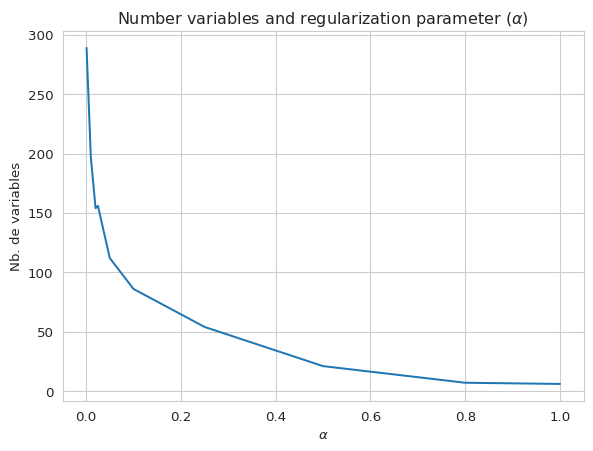

``` python
p.figure.get_figure()
```

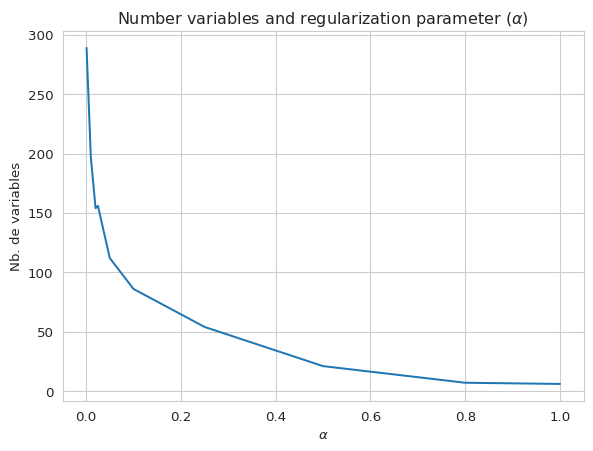

On voit que plus alpha est élevé, moins le modèle sélectionne de variables.

</div>

In [13]:
p.figure.get_figure().savefig("featured.png")

## Validation croisée pour sélectionner le modèle

Quel $\alpha$ faut-il privilégier ? Pour cela,
il convient d’effectuer une validation croisée afin de choisir le modèle pour
lequel les variables qui passent la phase de sélection permettent de mieux
prédire le résultat Républicain :

In [14]:
from sklearn.linear_model import LassoCV

df3 = df2.select_dtypes(include=np.number)
df3.replace([np.inf, -np.inf], np.nan, inplace=True)
df3 = df3.fillna(0)
scaler = StandardScaler()
yindex = df3.columns.get_loc("per_gop")
df3_scale = scaler.fit(df3).transform(df3)
# X_train, X_test , y_train, y_test = train_test_split(np.delete(data, yindex, axis = 1),data[:,yindex], test_size=0.2, random_state=0)

lcv = LassoCV(alphas=my_alphas ,normalize=False,fit_intercept=False,random_state=0,cv=5).fit(np.delete(df3_scale, yindex, axis = 1), df3_scale[:,yindex])

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.


In [15]:
print("alpha optimal :", lcv.alpha_)

alpha optimal : 0.001

In [16]:
lasso2 = Lasso(fit_intercept=True, alpha = lcv.alpha_).fit(X_train,y_train)
features_selec2 = df2.select_dtypes(include=np.number).drop("per_gop", axis = 1).columns[np.abs(lasso2.coef_)>0].tolist()

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.486e+03, tolerance: 6.352e+01


Les variables sélectionnées sont :

In [17]:
print(features_selec2)

['ALAND', 'AWATER', 'votes_gop', 'diff', 'Rural-urban_Continuum Code_2003', 'Rural-urban_Continuum Code_2013', 'Urban_Influence_Code_2013', 'Economic_typology_2015', 'CENSUS_2010_POP', 'N_POP_CHG_2013', 'N_POP_CHG_2016', 'N_POP_CHG_2017', 'N_POP_CHG_2018', 'N_POP_CHG_2019', 'Births_2011', 'Births_2015', 'Deaths_2015', 'Deaths_2017', 'Deaths_2018', 'NATURAL_INC_2012', 'NATURAL_INC_2013', 'NATURAL_INC_2014', 'NATURAL_INC_2016', 'NATURAL_INC_2018', 'INTERNATIONAL_MIG_2010', 'INTERNATIONAL_MIG_2011', 'INTERNATIONAL_MIG_2012', 'INTERNATIONAL_MIG_2013', 'INTERNATIONAL_MIG_2014', 'INTERNATIONAL_MIG_2015', 'INTERNATIONAL_MIG_2016', 'INTERNATIONAL_MIG_2017', 'INTERNATIONAL_MIG_2018', 'INTERNATIONAL_MIG_2019', 'DOMESTIC_MIG_2010', 'DOMESTIC_MIG_2012', 'DOMESTIC_MIG_2013', 'DOMESTIC_MIG_2015', 'DOMESTIC_MIG_2016', 'DOMESTIC_MIG_2018', 'NET_MIG_2011', 'NET_MIG_2014', 'NET_MIG_2018', 'NET_MIG_2019', 'RESIDUAL_2010', 'RESIDUAL_2011', 'RESIDUAL_2012', 'RESIDUAL_2013', 'RESIDUAL_2014', 'RESIDUAL_2015'

In [18]:
df2.select_dtypes(include=np.number).drop("per_gop", axis = 1).columns[np.abs(lasso2.coef_)>0]
nlasso = sum(np.abs(lasso2.coef_)>0)

``` python
print("Cela correspond à un modèle avec {} variables sélectionnées.".format(int(nlasso)))
```

Cela correspond à un modèle avec 206 variables sélectionnées.

<div class="alert alert-warning" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 1a : Régression linéaire avec scikit</h3>

Dans le cas où le modèle paraîtrait trop peu parcimonieux, il faudrait revoir la phase de définition des variables pertinentes pour comprendre si des échelles différentes de certaines variables ne seraient pas plus appropriées (par exemple du `log`).

</div>